# Experiment Results

## Details

- generation of inputs with [tribble](https://github.com/havrikov/tribble/)
- inputs generated from two grammars, one based on the current [URL standard](https://url.spec.whatwg.org/), the other one based on the RFC documents [RFC 3986](https://tools.ietf.org/html/rfc3986#appendix-A) and [RFC 6874](https://tools.ietf.org/html/rfc6874)
- experiment executed for both grammars with identical docker images
- for each run: 10 inputs selected at random from the generated inputs and added to the tests to execute
- run x contains all inputs used in runs 0..x-1 and 10 newly selected inputs
- execution of tests for 11 URL parsers:


*Language* | *URL Parser* | *Coverage Tool* 
--- | --- | ---
Firefox | nsURLParsers.cpp | grcov/genhtml
Chromium | url_parse.cc | coverage.py script
C | uriparser | LCOV 
C++ | POCO |LCOV 
Go | Package net/url | Package testing with coverage flags 
Java | java.net URL Class | JCOV 
JavaScript <br> | urijs <br> jsdom/whatwg-url| nyc/istanbul <br>
PHP | League URI | PHPUnit  
Python 3| urllib.parse | Coverage.py  
Ruby | Module URI |SimpleCov 

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas markdown matplotlib
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display, Markdown


# view results of 100 runs with single inputs added at "./smallExp/(ls | rfc)"
ls_df=pd.read_csv("./ls/experimentResultsMain.csv", index_col='run_nr').rename(columns=str.lower)

ls_df_comp=pd.read_csv("./ls/experimentResultsComponents.csv", index_col='run_nr').rename(columns=str.lower)

rfc_df=pd.read_csv("./rfc/experimentResultsMain.csv", index_col='run_nr').rename(columns=str.lower)
rfc_df_comp=pd.read_csv("./rfc/experimentResultsComponents.csv", index_col='run_nr').rename(columns=str.lower)

pd.set_option('display.float_format', lambda x: '%.2f' % x)


parsers=[c[:-4] for c in ls_df.columns.values if "-cov" in c]
colors_all = ['orange', 'darkblue', 'red', 'yellow', 'lightblue', 'purple', 'beige', 'grey', 'black', 'pink','green']
colors_map={}
chars = '0123456789ABCDEF'
# coloring
i=0
for p in parsers:
    c=colors_all[i] 
    colors_map[p]=c
    
    i+=1

comp_colors={}
for col in ls_df_comp.columns:
    if '_success-' in col:
        comp_colors[col]='#0'+''.join(random.sample(chars,5))
    elif '_success' in col:
        comp_colors[col]='#8'+''.join(random.sample(chars,5))
    else:
        comp_colors[col]='#F'+''.join(random.sample(chars,5))
for col in rfc_df_comp.columns:
    if col not in comp_colors:
        comp_colors[col]='#7'+''.join(random.sample(chars,5))
    
    
colors_comp = ['#2fb553', '#4a76bd']
ms=22

def setTickDistances(n, axs):
    ticks = axs.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in axs.xaxis.get_ticklabels()]
    axs.xaxis.set_ticks(ticks[::n])
    axs.xaxis.set_ticklabels(ticklabels[::n])
    return


The number of inputs added in each run (10) is large enough to reach the maximum coverage in the initial run for some parsers. To ensure that this is not caused by the test execution, an additional experiment in which single inputs are added was conducted. Results of this experiment can be viewed by using `./smallExp/ls` and `./smallExp/rfc` when loading csv files.





## Living Standard Results
### Tabular View

In [ ]:
ls_df.head(10)

In [ ]:
ls_df.tail(10)

### Overview Plot 

In [ ]:
def overviewPlot(df, title, xrange=None):
    fig, axs=plt.subplots(figsize=(40,20))
    plt.rcParams['font.size']='40'

    # apply some nice spacing
    if xrange is not None:
        a,b=xrange
        title+=" from run "+str(a)+" to run "+str(b)+" \n"
        xrange =(a-0.7, b+0.7)
    
    for p in parsers:
        plot=df[p+"-cov"].plot(title=title,
                       ylim=(0,100),xlim=xrange, ax=axs,
                       color=colors_map[p], style=".", ms=2*ms,
                      label=p.capitalize(), fontsize=40)
    


    plot.legend(bbox_to_anchor=(1,-0.2),markerscale=2.)
    plot.grid(True)

    axs.set_ylabel("Coverages", fontsize=40)
    axs.set_xlabel("Run", fontsize=40)
    
    vals = axs.get_yticks()
    axs.set_yticklabels(['{:.0f}'.format(x)+"%" for x in vals])
    
    #plt.show()
    plt.savefig('test.pdf')
    plt.show()
    
    display(Markdown("When directly comparing the coverages achieved in different parsers, one should always consider \
                    the number of lines coverable for each parser by simply parsing inputs. The coverages depicted here \
                    are calculated in relation to the total number of lines in each parser."))

In [ ]:
overviewPlot(ls_df,"Living Standard Coverages Overview\n", )

# plotting only selected runs
#overviewPlot(ls_df,"Living Standard Coverages Overview\n", (0,10) )
#overviewPlot(ls_df,"Living Standard Coverages Overview\n", (100,110) )





### Errors and Exceptions

In [ ]:
def errorsOverviewPlot(df, title):
    plt.rcParams['font.size']='30'
    fig, axs=plt.subplots(figsize=(20,15))
    
    new_df=pd.DataFrame()
    err_df=pd.DataFrame()

    print(df.tail(1)['nr-inputs'])
    for c in df.columns:
        if 'exceptions' in c:
            new_df[c]=df[c]
            err_df[c]=(df[c]/df['nr-inputs'])*100
        
    

    plot=df.tail(1).plot(kind='barh', title=title,
                       ax=axs, width=1.9,
                       y=[ cn for cn in df.columns if 'exceptions' in cn],
                       color=colors_map.values(), rot=0) 
    
    plot.legend(markerscale=2., loc=(1.2,0))
    plot.grid(True)


    for bar in plot.patches:
        plot.annotate(format(bar.get_width(), '.0f'), 
                    (bar.get_width() ,bar.get_y() + bar.get_height() / 3 ),
                    ha='left',  xytext=(5, 0), 
                   textcoords='offset points', color='dimgrey')


    
    axs.set_ylabel("Run", fontsize=40)
    axs.set_xlabel("\nExceptions", fontsize=40)
    axs.set_axisbelow(True)
    
    plt.show()
    display(Markdown("The above diagram compares the number of parsing exceptions encountered for each parser in \
                    the last available run with "+str(df['nr-inputs'].max()) +" distinct inputs."))
    
    display(new_df.tail(1).transpose())
    display(err_df.tail(1).transpose())
    return err_df
    
def errorsOverTime(df, title, xrange=None):
    plt.rcParams['font.size']='40'
    fig2, axs2=plt.subplots(figsize=(50,20))
    
    # apply some nice spacing
    if xrange is not None:
        a,b=xrange
        title+=" from run "+str(a)+" to run "+str(b)+" \n"
        xrange =(a-0.7, b+0.7)
    
    
    for p in parsers:
        plot2=df[p+"-exceptions"].plot(title=title,
                        ax=axs2,xlim=xrange,
                       color=colors_map[p], style=".", ms=ms,
                      label=p.capitalize(), fontsize=40)
    plot2.grid(True)
    plot2.legend(markerscale=2., loc='best')
    axs2.set_ylabel("Exceptions\n", fontsize=40)
    axs2.set_xlabel("\nRun", fontsize=40)
    axs2.set_axisbelow(True)
    plt.show()

In [ ]:

errorsOverviewPlot(ls_df, "Living Standard Exceptions Overview\n")
errorsOverTime(ls_df, "Exceptions over time\n")
# errors within a specific range
# errorsOverTime(ls_df, "Exceptions over time\n", (0,100))


### Equal and Unequal Results

In [ ]:
def equalResultsOverview(df, title):
    fig, axs=plt.subplots(figsize=(30,15))
    plt.rcParams['font.size']='30'

    new_df=pd.DataFrame()
    b_new_df=pd.DataFrame()
    for c in df.columns:
        if 'result' in c:
            if 'b-' in c:
                b_new_df[c]=df[c]
            else:
                new_df[c]=df[c]
    
    
    plot=new_df.iloc[::df['nr-inputs'].max()//100].plot(kind='bar', stacked=True, ax=axs, rot=0,
                     color=['g', 'pink', 'r'], title=title)
    
    for container, hatch in zip(plot.containers, ("/", ".")):
        for patch in container.patches:
            patch.set_hatch(hatch)
    
    n=df['nr-inputs'].max()/100
    #setTickDistances(int(n), axs)
    
    plot.grid(True)
    plot.legend(loc='best')
    axs.set_ylabel("Inputs", fontsize=40)
    axs.set_axisbelow(True)
    plt.show()
    display(Markdown("In the above diagram a ``eq-success-result`` means that all considered parsers successfully parsed \
    the input. A ``eq-fail-result`` means that all parsers rejected the given input and a ``neq-result`` means that \
    some parsers accepted the input as valid while other parsers rejected the input."))
    return b_new_df

In [ ]:
ls_b_new_df=equalResultsOverview(ls_df, "Living Standard Parser Equality\n")

In [ ]:
def browserEquality(df, title):
    fig, axs=plt.subplots(figsize=(30,15))
    plt.rcParams['font.size']='30'
    nr_inputs=sum([df[col].tail(1) for col in df.columns if 'result' in col])
    n=int(nr_inputs)//100
    plot=df.iloc[::n].plot(kind='bar', stacked=True, rot=0, ax=axs, 
            color=['g', 'pink', 'orange', 'lightblue', 'r'], title=title)
    axs.set_ylabel("Inputs", fontsize=40)
    plot.grid(True)
    axs.set_axisbelow(True)
    for container, hatch in zip(plot.containers, ("/", ".", "\\", "x")):
        for patch in container.patches:
            patch.set_hatch(hatch)
    
    plot.grid(True)
    plot.legend(loc='best')
    plt.show()
    

In [ ]:
browserEquality(ls_b_new_df, "Living Standard Browser Results Equality\n")
display(Markdown("Much like the previous diagram, this diagram differs between equal and unequal parsing results. \
                    Because only the results of the tested browsers are considered, the diagram can also show whether \
                    the browsers failed on the same components, on different components, or if the results were completely \
                    unequal i.e. one rejection and one component failure."))

#### Browser Components

In [ ]:
def browserComponentComparison(df_comp, title):
    fig, axs=plt.subplots(figsize=(45,25))
    plt.rcParams['font.size']='30'

    new_df=pd.DataFrame()
    for c in df_comp.columns:
        if 'nr' not in c:
            new_df[c]=df_comp[c]
    
    colors=[comp_colors[name] for name in new_df.columns]
    nr_inputs=sum([new_df[col].tail(1) for col in new_df.columns])
    n=int(nr_inputs)//100
    plot=new_df.iloc[::n].plot(kind='bar', stacked=True, ax=axs, rot=0, color=colors ,
                     title=title)
    axs.set_ylabel("Inputs", fontsize=40)
    
    plot.grid(True)
    
    try:
        plot.legend(loc=(0,-0.4), ncol=len(new_df.columns)//5)
    except:
        plot.legend(loc='best')
    axs.set_axisbelow(True)
    plt.show()
    display(Markdown("The above diagram shows in detail which combination of results was \
            observed for the considered browsers. The following table shows the combination \
            of results of the last available run in numerical form."))
    
    
    trdf=new_df.tail(1).transpose()
    #trdf=new_df.head(1000).tail(1).transpose()
    display(trdf.sort_values([c for c in trdf.columns], ascending=False).style.format('{:.0f}'))

In [ ]:
absolute_inputs=ls_df_comp.tail(1)['nr_inputs']


browserComponentComparison(ls_df_comp, "Living Standard Browser Component Equality\n")




#### Separately for each Browser

Considering the latest available run for each figure.

In [ ]:
def browserComponentDetail(browser, df, run_nr=-1, abs_inputs=-1, 
                           components=['scheme', 'username', 'password', 'host', 'port', 'path', 'query', 'fragment']):
    
    # select the specified run, default: last run
    if run_nr < 0 :
        df=df.tail(1)
    else:
        df=df.head(run_nr+1).tail(1)
    plt.rcParams['font.size']='20'
    fig, axs=plt.subplots( figsize=(25,15))
    
    
    full_df=pd.DataFrame()
    for component in components:
        # count the relevant columns
        if abs_inputs>0:
            inputs=abs_inputs #use exact nr of unique inputs
        else:
            inputs=int(df['nr_inputs'])
        new_df=pd.DataFrame()
        
        sumcomponent=0
        for c in df.columns:
            if browser+'_'+component in c:
                new_df[c]=df[c]
                sumcomponent+=int(df[c])
        
        new_df['component']=[component]
        new_df['other']=[inputs-sumcomponent]
        full_df=pd.concat([full_df, new_df], ignore_index=True, sort=True)
    
    
    comp_colors2=comp_colors
    comp_colors2['other']='dimgrey'
    
    colors=[comp_colors[name] for name in full_df.columns if name != 'component']
    
    plot=full_df.plot( kind='bar', stacked=True, ax=axs,x='component',
                         color=colors,
                         rot=0, title=browser.capitalize()+" Details\n")
    plt.show()
    
    full_df=full_df.set_index('component')
    format_dict={}
    for cl in full_df.select_dtypes(float).columns:
        format_dict[cl]='{:.0f}'
    display(full_df.head(10).style.format(format_dict))
    display(Markdown('Each table row shows which result combinations occured when the given browser had a component \
            mismatch for the specified component. The column \'other\' represents all results where the given browser \
            did not have a component mismatch for the specified component.'))
    
    
    #calculate percentages
    trdf=full_df.transpose()
    if abs_inputs>0:
        absolute_inputs=abs_inputs
    else:
        absolute_inputs=df.tail(1)['nr_inputs']
    
    err_p_df=pd.DataFrame()
    for c in trdf.columns:
        p= 1-(trdf[c]['other']/absolute_inputs)
        err_p_df[c]=[p]
        
    err_p_df=err_p_df.rename(index={0:browser})
    
    return err_p_df.transpose() #used for table creation
    

View the full results of this run [here](./ls/lastRun/resultOverview.html).

The following graphs show which parsing result the other browser had when one browser had a component mismatch. 

In [ ]:

browserComponentDetail('firefox', ls_df_comp, abs_inputs=int(ls_df.tail(1)['nr-inputs']))
browserComponentDetail('chromium', ls_df_comp,abs_inputs=int(ls_df.tail(1)['nr-inputs']))


These graphs only include results where at least one browser had a component mismatch.
Further below are graphs where at least one browser successfully parsed or immediately rejected the input.

#### Parsing Success and Rejection

A parsing success means that the parser accepted the given input as valid URL and all URL components had the expected content. A rejection means that the parser did not accept the given input as valid URL and no component checks were performed. Between these outcomes lies a third possible outcome: the parser accepts the given input as valid URL but at least one component did not have the expected content.

The following figures show which result one browser had when the other browser successfully parsed a URL or when it rejected the URL. 

In [ ]:
def browserDetail(browser, df, run_nr=-1):
    
    # select the specified run, default: last run
    if run_nr < 0 :
        df=df.tail(1)
    else:
        df=df.head(run_nr+1).tail(1)
    plt.rcParams['font.size']='10'
    plt.rcParams['figure.figsize'] = (16,7)
    fig, axs=plt.subplots(1,2)
    #fig2, axs2=plt.subplots( figsize=(8,8))
    
    full_df=pd.DataFrame()
    for component in ['success', 'reject']:
        
        # count the relevant columns
        inputs=int(df['nr_inputs'])
        new_df=pd.DataFrame()
        
        sumcomponent=0
        for c in df.columns:
            if browser+'_'+component in c:
                new_df[c]=df[c]
                sumcomponent+=int(df[c])
        
        new_df['result']=[component]
        
        full_df=pd.concat([full_df, new_df], ignore_index=True, sort=True)
        
        
    full_df=full_df.set_index('result')
    display(full_df.style.format('{:.0f}'))
    tr_df=full_df.transpose().sort_values(by=['success', 'reject'])
    plot=tr_df.plot( kind='pie',ax=axs[0], 
                         colormap='Greens', y='success',
                         labels=None,
                         legend=False)
    
    plot.legend(loc=(0.2,-0.2), labels=[c for c in tr_df.transpose().columns if tr_df['success'][c]>0],fontsize=12)
    
    plot2=full_df.transpose().sort_values(by=['reject']).plot( kind='pie',ax=axs[1],
                         colormap='YlOrRd', y='reject',
                         labels=None, legend=False)
    plot2.legend(loc=(0.2,-0.2),labels=[c for c in tr_df.transpose().columns if tr_df['reject'][c]>0], fontsize=12)
    display(Markdown("### <center>"+browser.capitalize()+" Details</center>\n"))
    plt.show()
    display(Markdown("Note that these pie charts **only** show the other browsers results for \
    success or reject results of the specified browser. The different component combinations are \
    discussed above."))

In [ ]:
browserDetail('firefox', ls_df_comp)


In [ ]:
browserDetail('chromium', ls_df_comp)

## RFC Results

### Tabular View

In [ ]:
rfc_df.head(10)

In [ ]:
rfc_df.tail(10)

### Coverages Overview Plot

In [ ]:
overviewPlot(rfc_df,"RFC Coverages Overview\n" )
# plotting only selected runs
#overviewPlot(rfc_df,"RFC Coverages Overview\n", (0,10) )
#overviewPlot(rfc_df,"RFC Coverages Overview\n", (100,110) )

### Errors and Exceptions Overview

In [ ]:
errorsOverviewPlot(rfc_df, "RFC Exceptions Overview\n") 
errorsOverTime(rfc_df, "Exceptions over time\n") 

### Equal and Unequal Results

In [ ]:
rfc_b_new_df=equalResultsOverview(rfc_df, "RFC Results Parser Equality\n")

In [ ]:
browserEquality(rfc_b_new_df, "RFC Browser Results Equality\n") 
display(Markdown("Because component checks are currently only implemented for ``url-fuzzing/grammars/livingstandard-url.scala`` \
            the above diagram only contains entries where no component checks are required. Similarly, the next diagram \
            only contains entries for parsing success or rejection."))

In [ ]:
browserComponentComparison(rfc_df_comp, "RFC Browser Component Equality\n")

### Detailed Browser Comparison

Considering the last available run. View the full results of this run [here](./rfc/lastRun/resultoverview.html).

In [ ]:
browserDetail('firefox', rfc_df_comp)


In [ ]:
browserDetail('chromium', rfc_df_comp)

## Detailed per Parser Comparison of Grammars

In [73]:
from IPython.display import display, Markdown

ffexcov=74.7 
ffwptcov=84.4
chrexcov=82.71
chrwptcov=64.29

source_reports={}
source_reports["chromium"]="chromium/report.html"
source_reports["firefox"]="firefox/nsURLParsers.cpp.gcov.html" 
source_reports["c"]="C/src/UriParse.c.gcov.html"
source_reports["cpp"]="Cpp/src/URI.cpp.gcov.html"
source_reports["go"]="Go/index.html"
source_reports["java"]="Java/java/net/URL.html" 
source_reports["javascripturijs"]="JavaScript/urijs/URI.js.html"
source_reports["javascriptwhatwg-url"]="JavaScript/whatwg-url/whatwg-url/dist/url-state-machine.js.html"
source_reports["php"]="PHP/index.html"
source_reports["python"]="Python/_usr_lib_python3_6_urllib_parse_py.html"
source_reports["ruby"]="Ruby/index.html"



def compareGrammarResults(parser, df1, newcolumn1, df2, newcolumn2, xrange=None):
    display(Markdown("### "+parser.capitalize()))
    plt.rcParams['font.size']='40'
    fig, axs=plt.subplots(figsize=(40,20))
    
    
    title=parser.capitalize()+" Coverages\n"
    # apply some nice spacing
    if xrange is not None:
        a,b=xrange
        title+=" from run "+str(a)+" to run "+str(b)+" \n"
        xrange =(a-0.7, b+0.7)

    new_df=pd.DataFrame()
    new_df[newcolumn1]=df1[parser+"-cov"]
    new_df[newcolumn2]=df2[parser+"-cov"]

    plot=new_df.plot(title=title,ylim=(0,100), xlim=xrange,
                     ax=axs, style=".", color=colors_comp, ms=ms)
    
    plot.grid(True)
    

    axs.set_ylabel("Coverages", fontsize=40)
    axs.set_xlabel("Run", fontsize=40)
    otherTests=""
    
    if parser=='firefox': 
        plot.axhline(y=ffexcov, color='black', linestyle=':', lw=4, label='Existing Test Files')
        otherTests+="Existing Test Files Coverage: "+str(ffexcov)+"%"
        otherTests+=" [coverage report](./otherTestResults/firefoxExistingTests/firefoxExistingTestsFull/nsURLParsers.cpp.gcov.html)"
        plot.axhline(y=ffwptcov, color='y', linestyle=':', lw=4, label='WPT tests')
        otherTests+="\n\nWeb platform tests Coverage: "+str(ffwptcov)+"%"
        otherTests+=" [coverage report](./otherTestResults/firefoxWPTReports/firefoxWPTFullURLs/nsURLParsers.cpp.gcov.html)"
    if parser=='chromium':
        plot.axhline(y=chrexcov, color='black', linestyle=':', lw=4, label='Existing Test Files')
        otherTests+="Existing Test Files Coverage: "+str(chrexcov)+"%"
        otherTests+=" [coverage report](./otherTestResults/chromiumExistingTests/chromiumExistingFull/report.html)"
        plot.axhline(y=chrwptcov, color='y', linestyle=':', lw=4, label='WPT tests')
        otherTests+="\n\nWeb platform tests Coverage: "+str(chrwptcov)+"%"
        otherTests+=" [coverage report](./otherTestResults/chromiumWPTReports/chromiumFullWPT/report.html)"
    plot.legend(loc='best',markerscale=2.)
    plt.show()
    if xrange is not None:
        display(Markdown("#### Results from run "+str(a)+" to run "+str(b)))
        display(new_df[a:b].describe())
        display(Markdown(newcolumn1+" Max Coverage: "+str(new_df[a:b][newcolumn1].max())+"% \
                     reached in run "+str(new_df[a:b][newcolumn1].idxmax())+" "))
        display(Markdown(newcolumn2+" Max Coverage: "+str(new_df[a:b][newcolumn2].max())+"% \
                     reached in run "+str(new_df[a:b][newcolumn2].idxmax())+" "))
        display(Markdown(otherTests))
    else:
        display(new_df.describe())
        
    display(Markdown("#### Overall max results"))
    display(Markdown(newcolumn1+" Max Coverage: "+str(new_df[newcolumn1].max())+"% \
                     reached in run "+str(new_df[newcolumn1].idxmax())+" \
                     \n\n[full max run results](./ls/"+parser+"/resultoverview.html) \
                     \n\n[coverage report](./ls/"+parser+"/"+source_reports[parser]+")"))
    
    display(Markdown(newcolumn2+" Max Coverage: "+str(new_df[newcolumn2].max())+"% \
                     reached in run "+str(new_df[newcolumn2].idxmax())+"\
                     \n\n[full max run results](./rfc/"+parser+"/resultoverview.html)\
                     \n\n[coverage report](./rfc/"+parser+"/"+source_reports[parser]+")"))
    display(Markdown(otherTests))
    
    return new_df, plot



### C

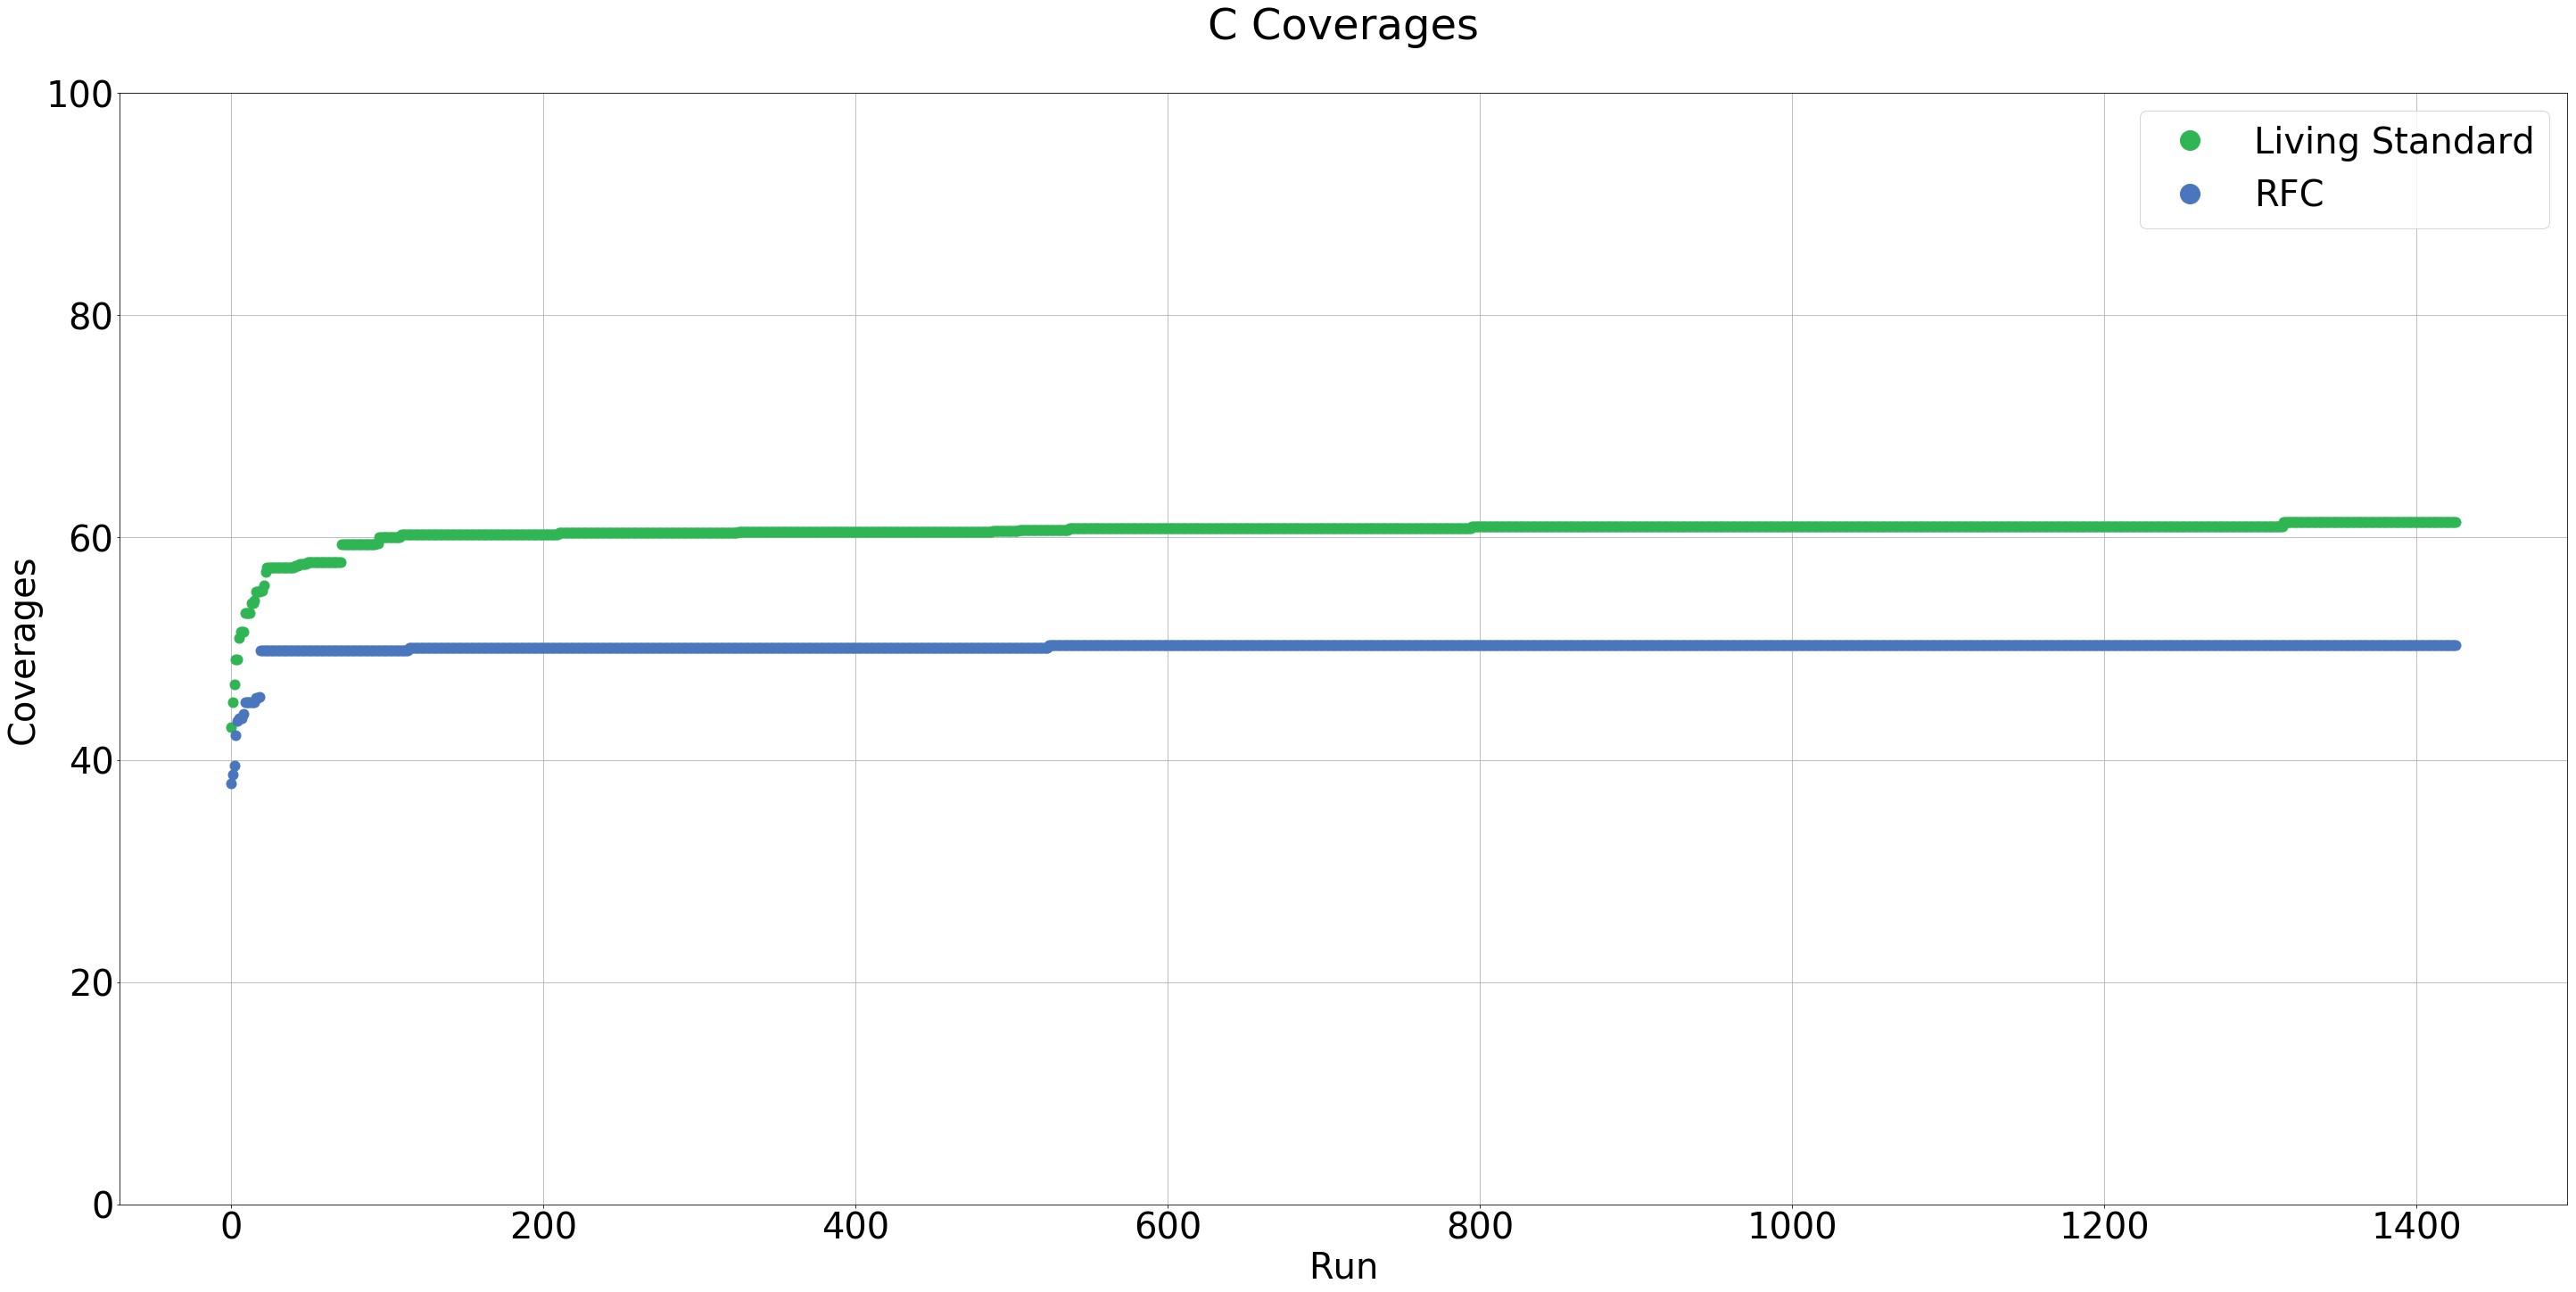

,Living Standard,RFC
count,1426.00,1426.00
mean,60.54,50.12
std,1.33,0.81
min,42.90,37.90
25%,60.50,50.10
50%,60.80,50.30
75%,61.00,50.30
max,61.40,50.30


#### Overall max results

Living Standard Max Coverage: 61.4%                      reached in run 1315                      

[full max run results](./ls/c/resultoverview.html)                      

[coverage report](./ls/c/C/src/UriParse.c.gcov.html)

RFC Max Coverage: 50.3%                      reached in run 524                     

[full max run results](./rfc/c/resultoverview.html)                     

[coverage report](./rfc/c/C/src/UriParse.c.gcov.html)

### Chromium

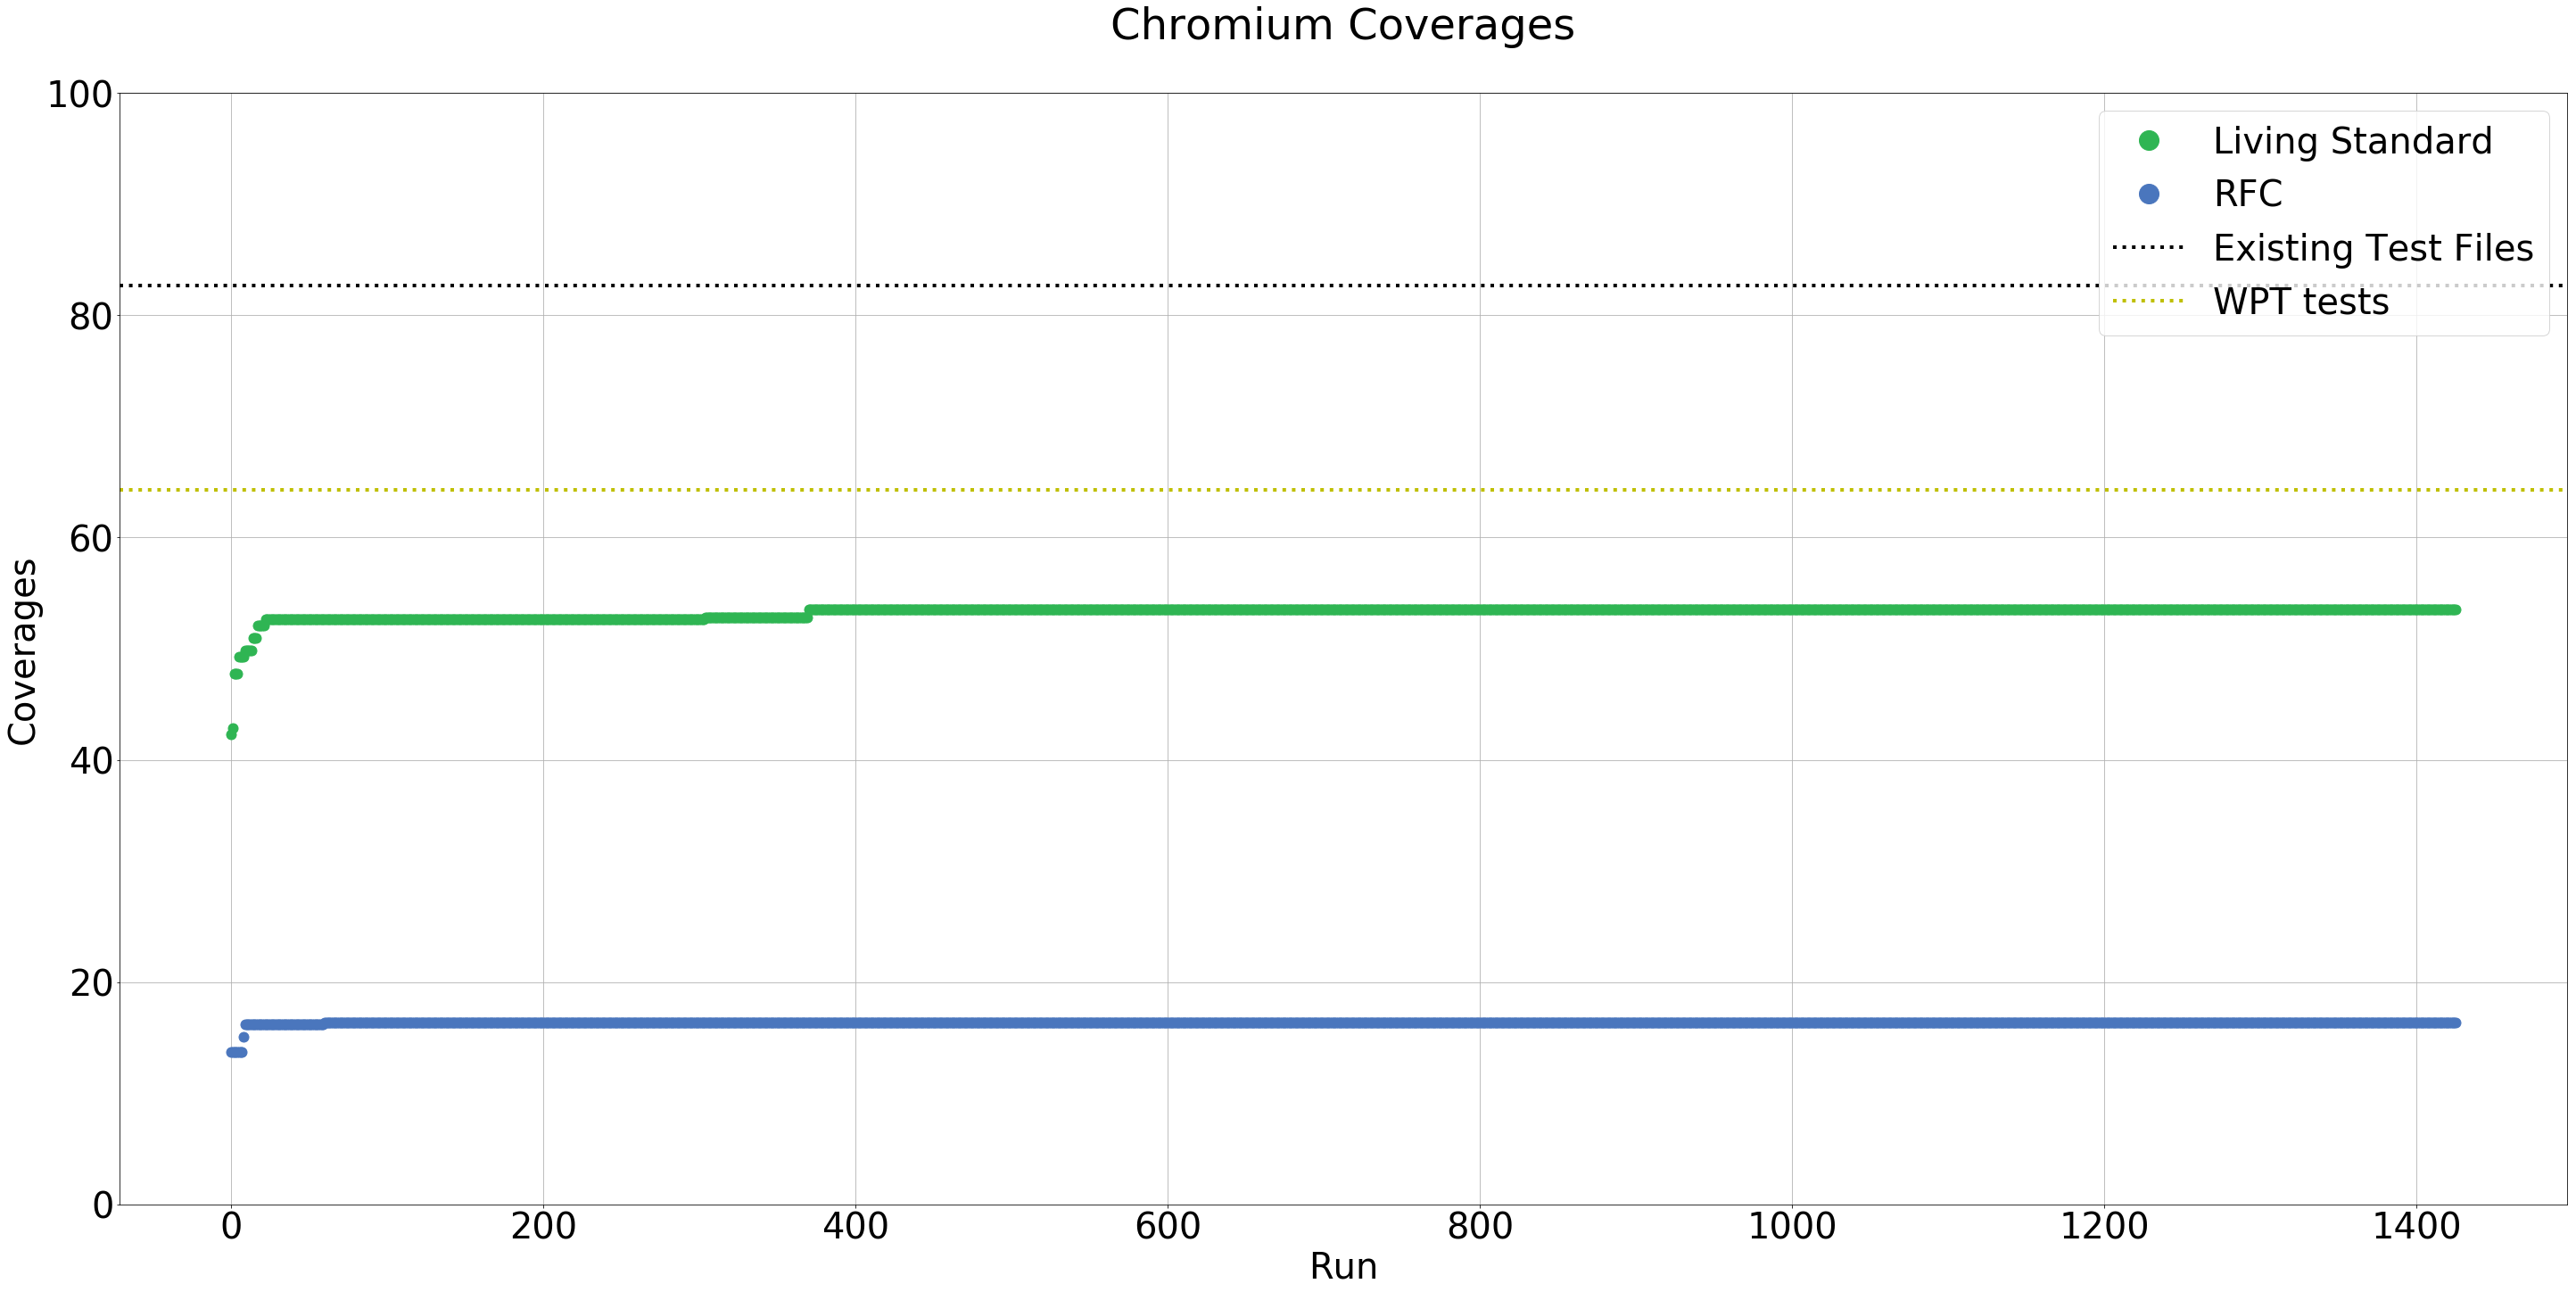

,Living Standard,RFC
count,1426.00,1426.00
mean,53.29,16.33
std,0.70,0.20
min,42.29,13.72
25%,52.82,16.35
50%,53.57,16.35
75%,53.57,16.35
max,53.57,16.35


#### Overall max results

Living Standard Max Coverage: 53.57%                      reached in run 370                      

[full max run results](./ls/chromium/resultoverview.html)                      

[coverage report](./ls/chromium/chromium/report.html)

RFC Max Coverage: 16.35%                      reached in run 60                     

[full max run results](./rfc/chromium/resultoverview.html)                     

[coverage report](./rfc/chromium/chromium/report.html)

Existing Test Files Coverage: 82.71% [coverage report](./otherTestResults/chromiumExistingTests/chromiumExistingFull/report.html)

Web platform tests Coverage: 64.29% [coverage report](./otherTestResults/chromiumWPTReports/chromiumFullWPT/report.html)

### Cpp

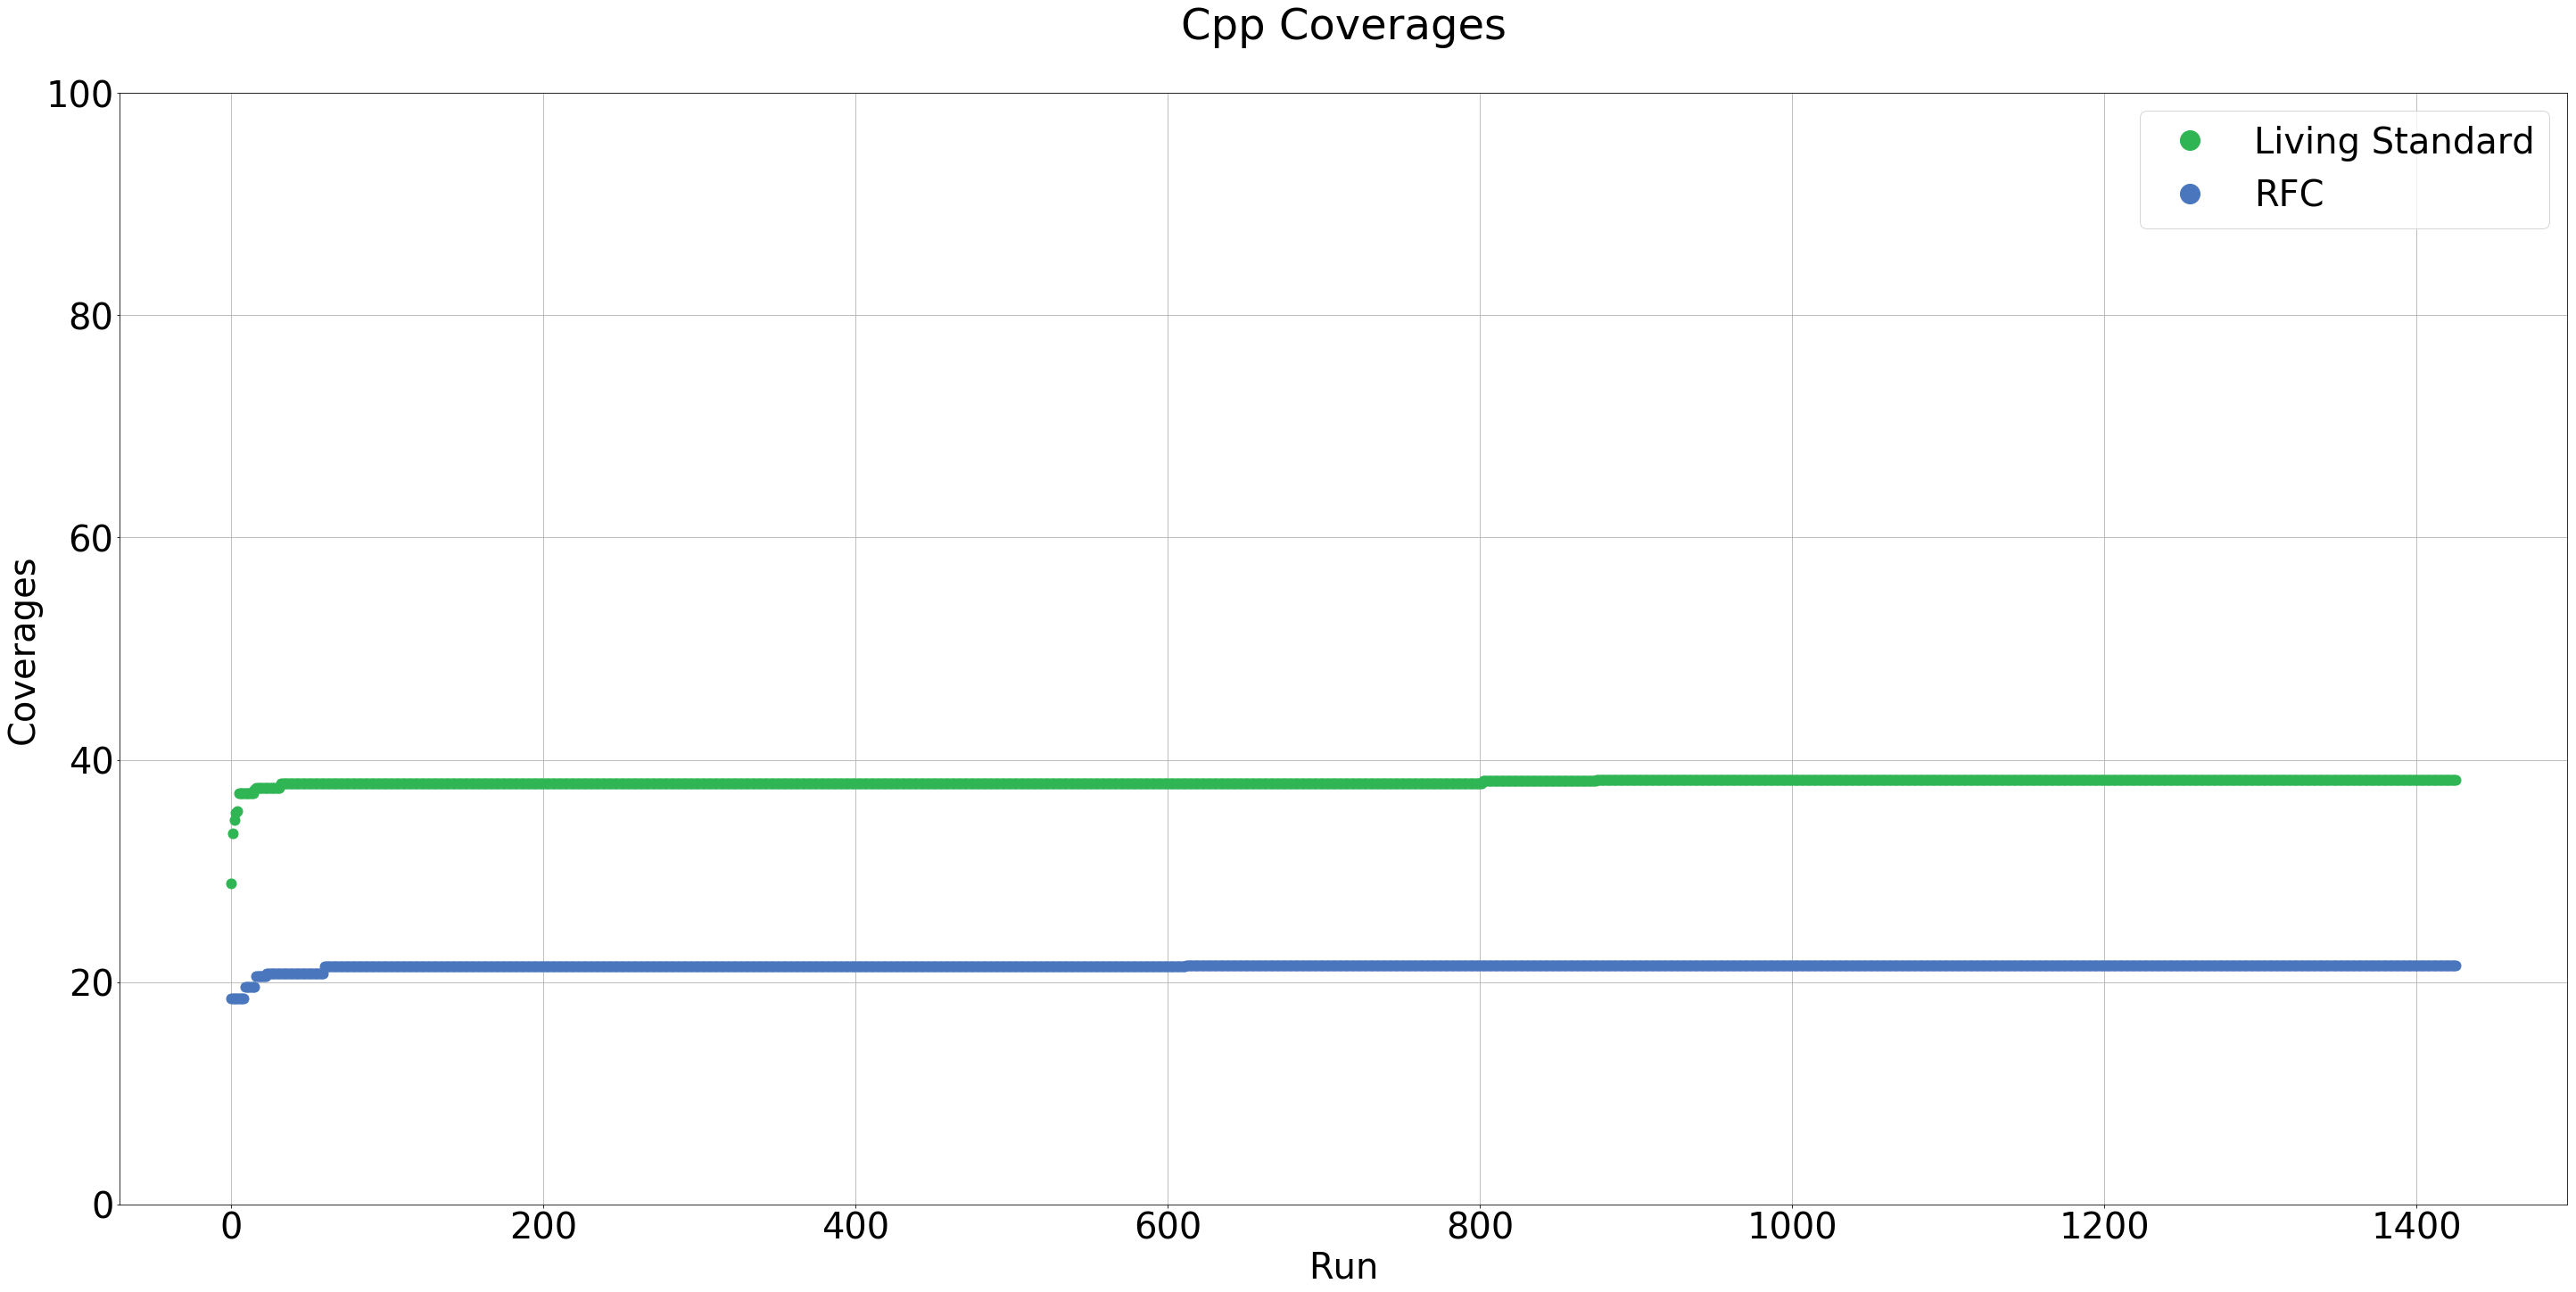

,Living Standard,RFC
count,1426.00,1426.00
mean,38.00,21.41
std,0.35,0.30
min,28.90,18.50
25%,37.90,21.40
50%,37.90,21.50
75%,38.20,21.50
max,38.20,21.50


#### Overall max results

Living Standard Max Coverage: 38.2%                      reached in run 875                      

[full max run results](./ls/cpp/resultoverview.html)                      

[coverage report](./ls/cpp/Cpp/src/URI.cpp.gcov.html)

RFC Max Coverage: 21.5%                      reached in run 612                     

[full max run results](./rfc/cpp/resultoverview.html)                     

[coverage report](./rfc/cpp/Cpp/src/URI.cpp.gcov.html)

### Firefox

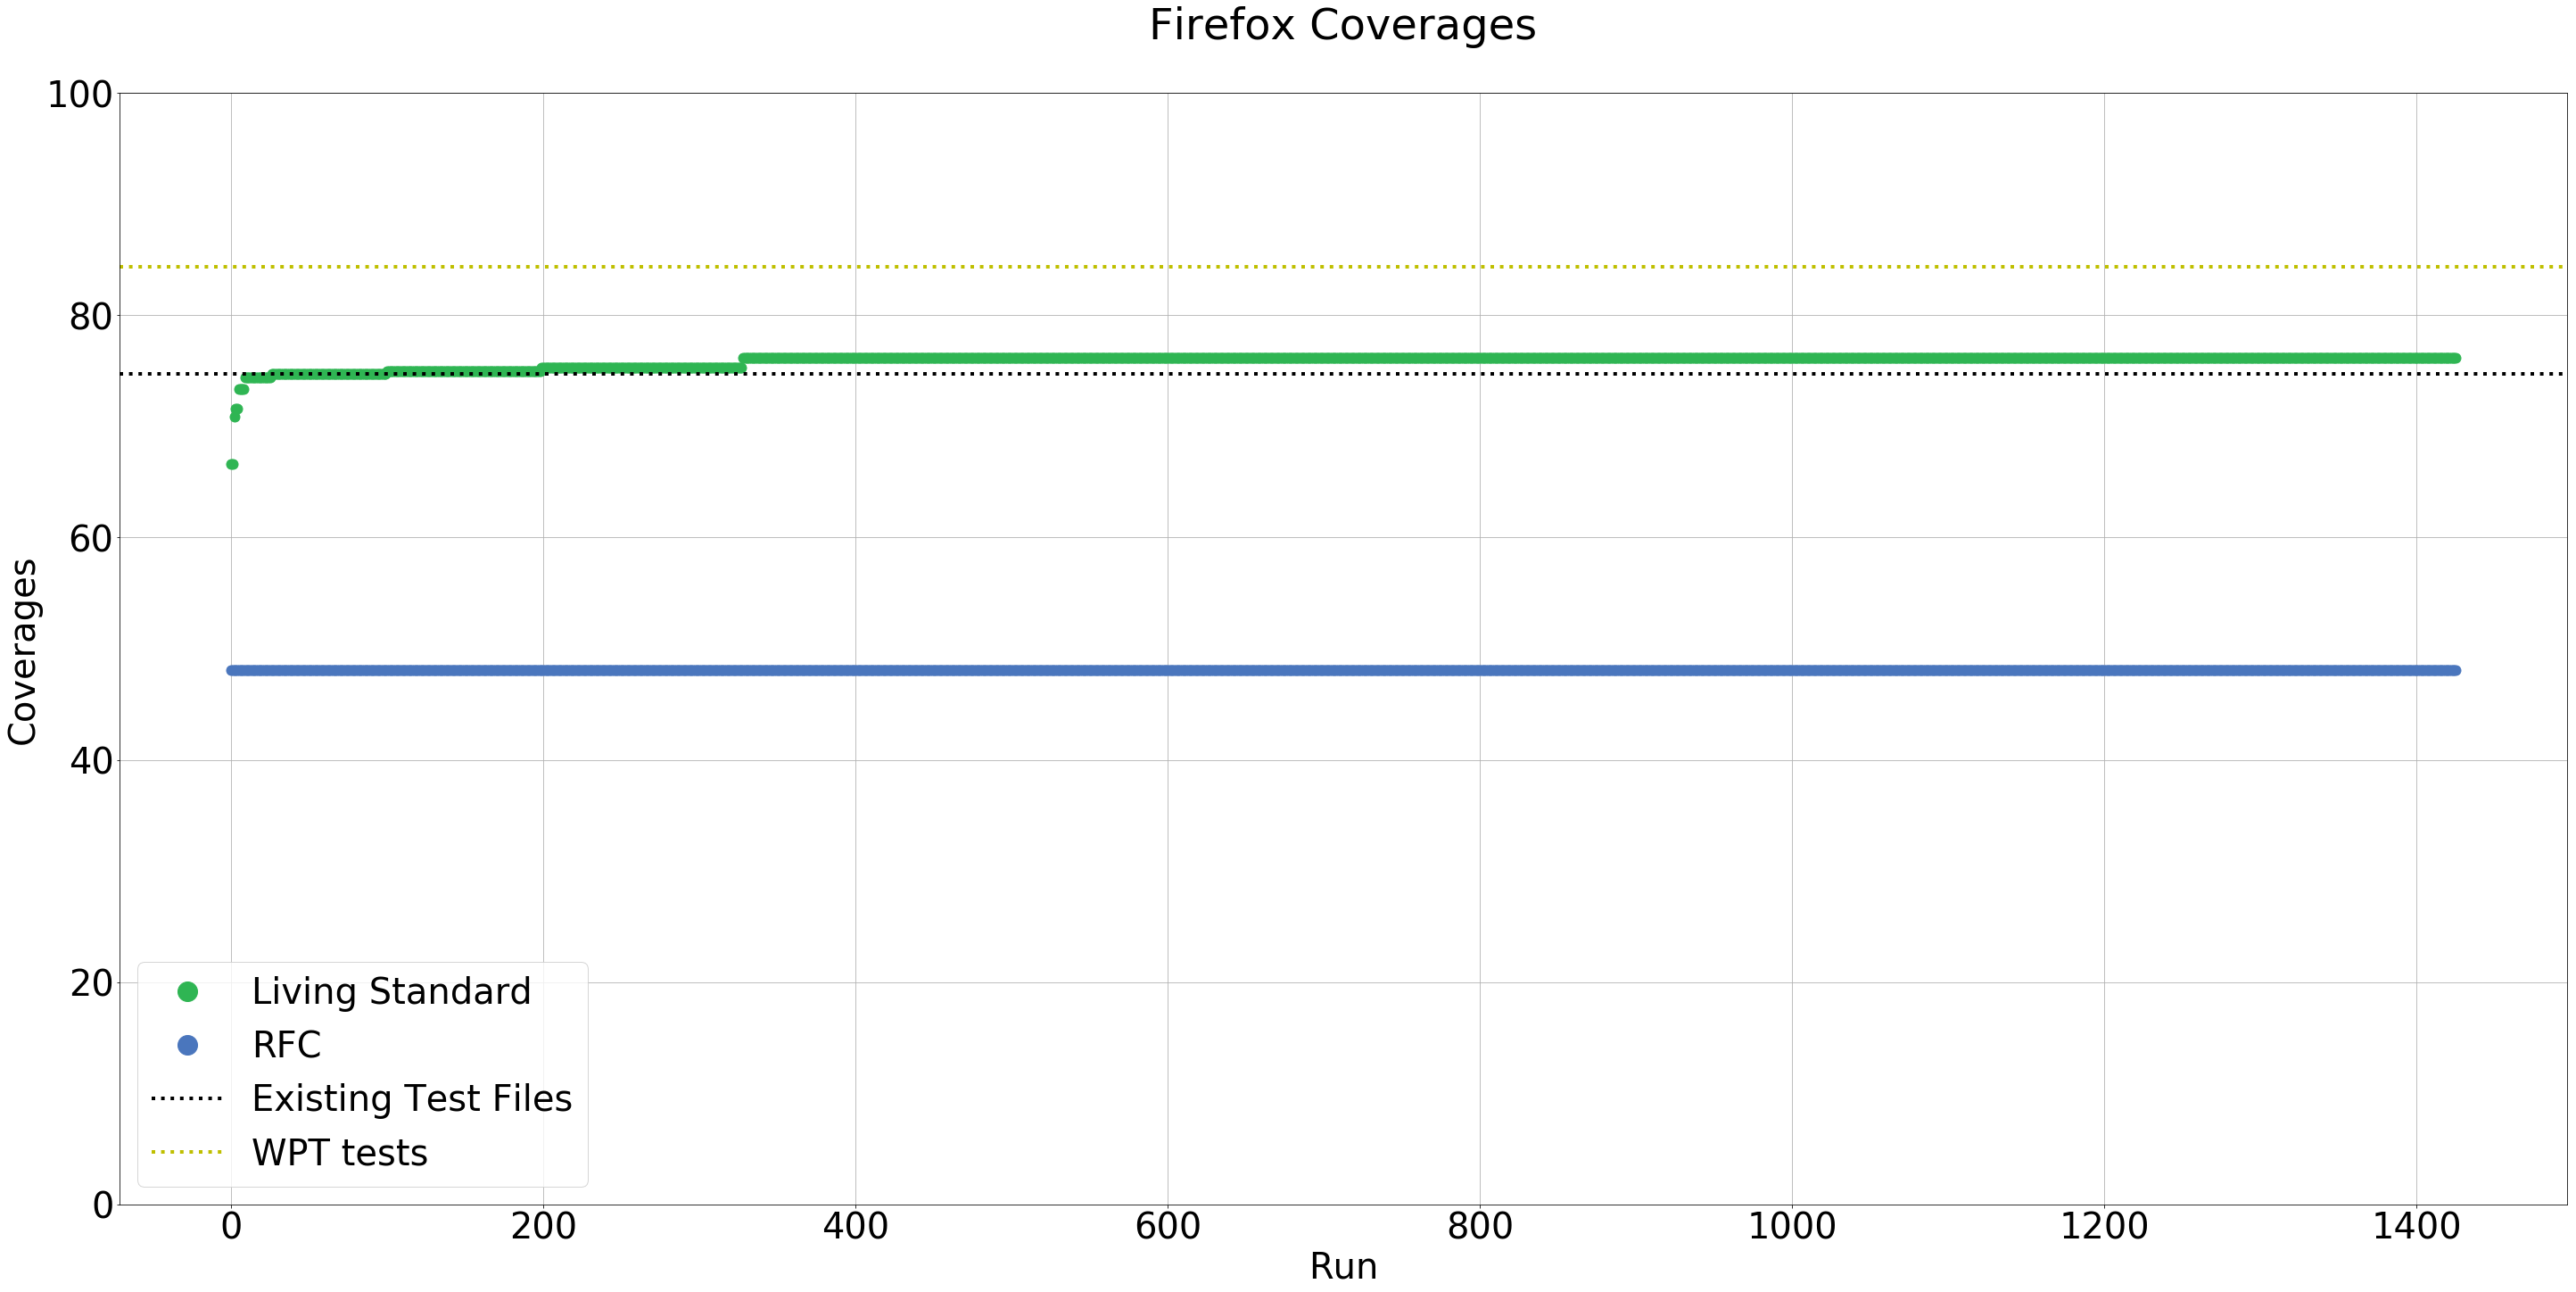

,Living Standard,RFC
count,1426.00,1426.00
mean,75.90,48.10
std,0.67,0.00
min,66.60,48.10
25%,76.20,48.10
50%,76.20,48.10
75%,76.20,48.10
max,76.20,48.10


#### Overall max results

Living Standard Max Coverage: 76.2%                      reached in run 328                      

[full max run results](./ls/firefox/resultoverview.html)                      

[coverage report](./ls/firefox/firefox/nsURLParsers.cpp.gcov.html)

RFC Max Coverage: 48.1%                      reached in run 0                     

[full max run results](./rfc/firefox/resultoverview.html)                     

[coverage report](./rfc/firefox/firefox/nsURLParsers.cpp.gcov.html)

Existing Test Files Coverage: 74.7% [coverage report](./otherTestResults/firefoxExistingTests/firefoxExistingTestsFull/nsURLParsers.cpp.gcov.html)

Web platform tests Coverage: 84.4% [coverage report](./otherTestResults/firefoxWPTReports/firefoxWPTFullURLs/nsURLParsers.cpp.gcov.html)

### Go

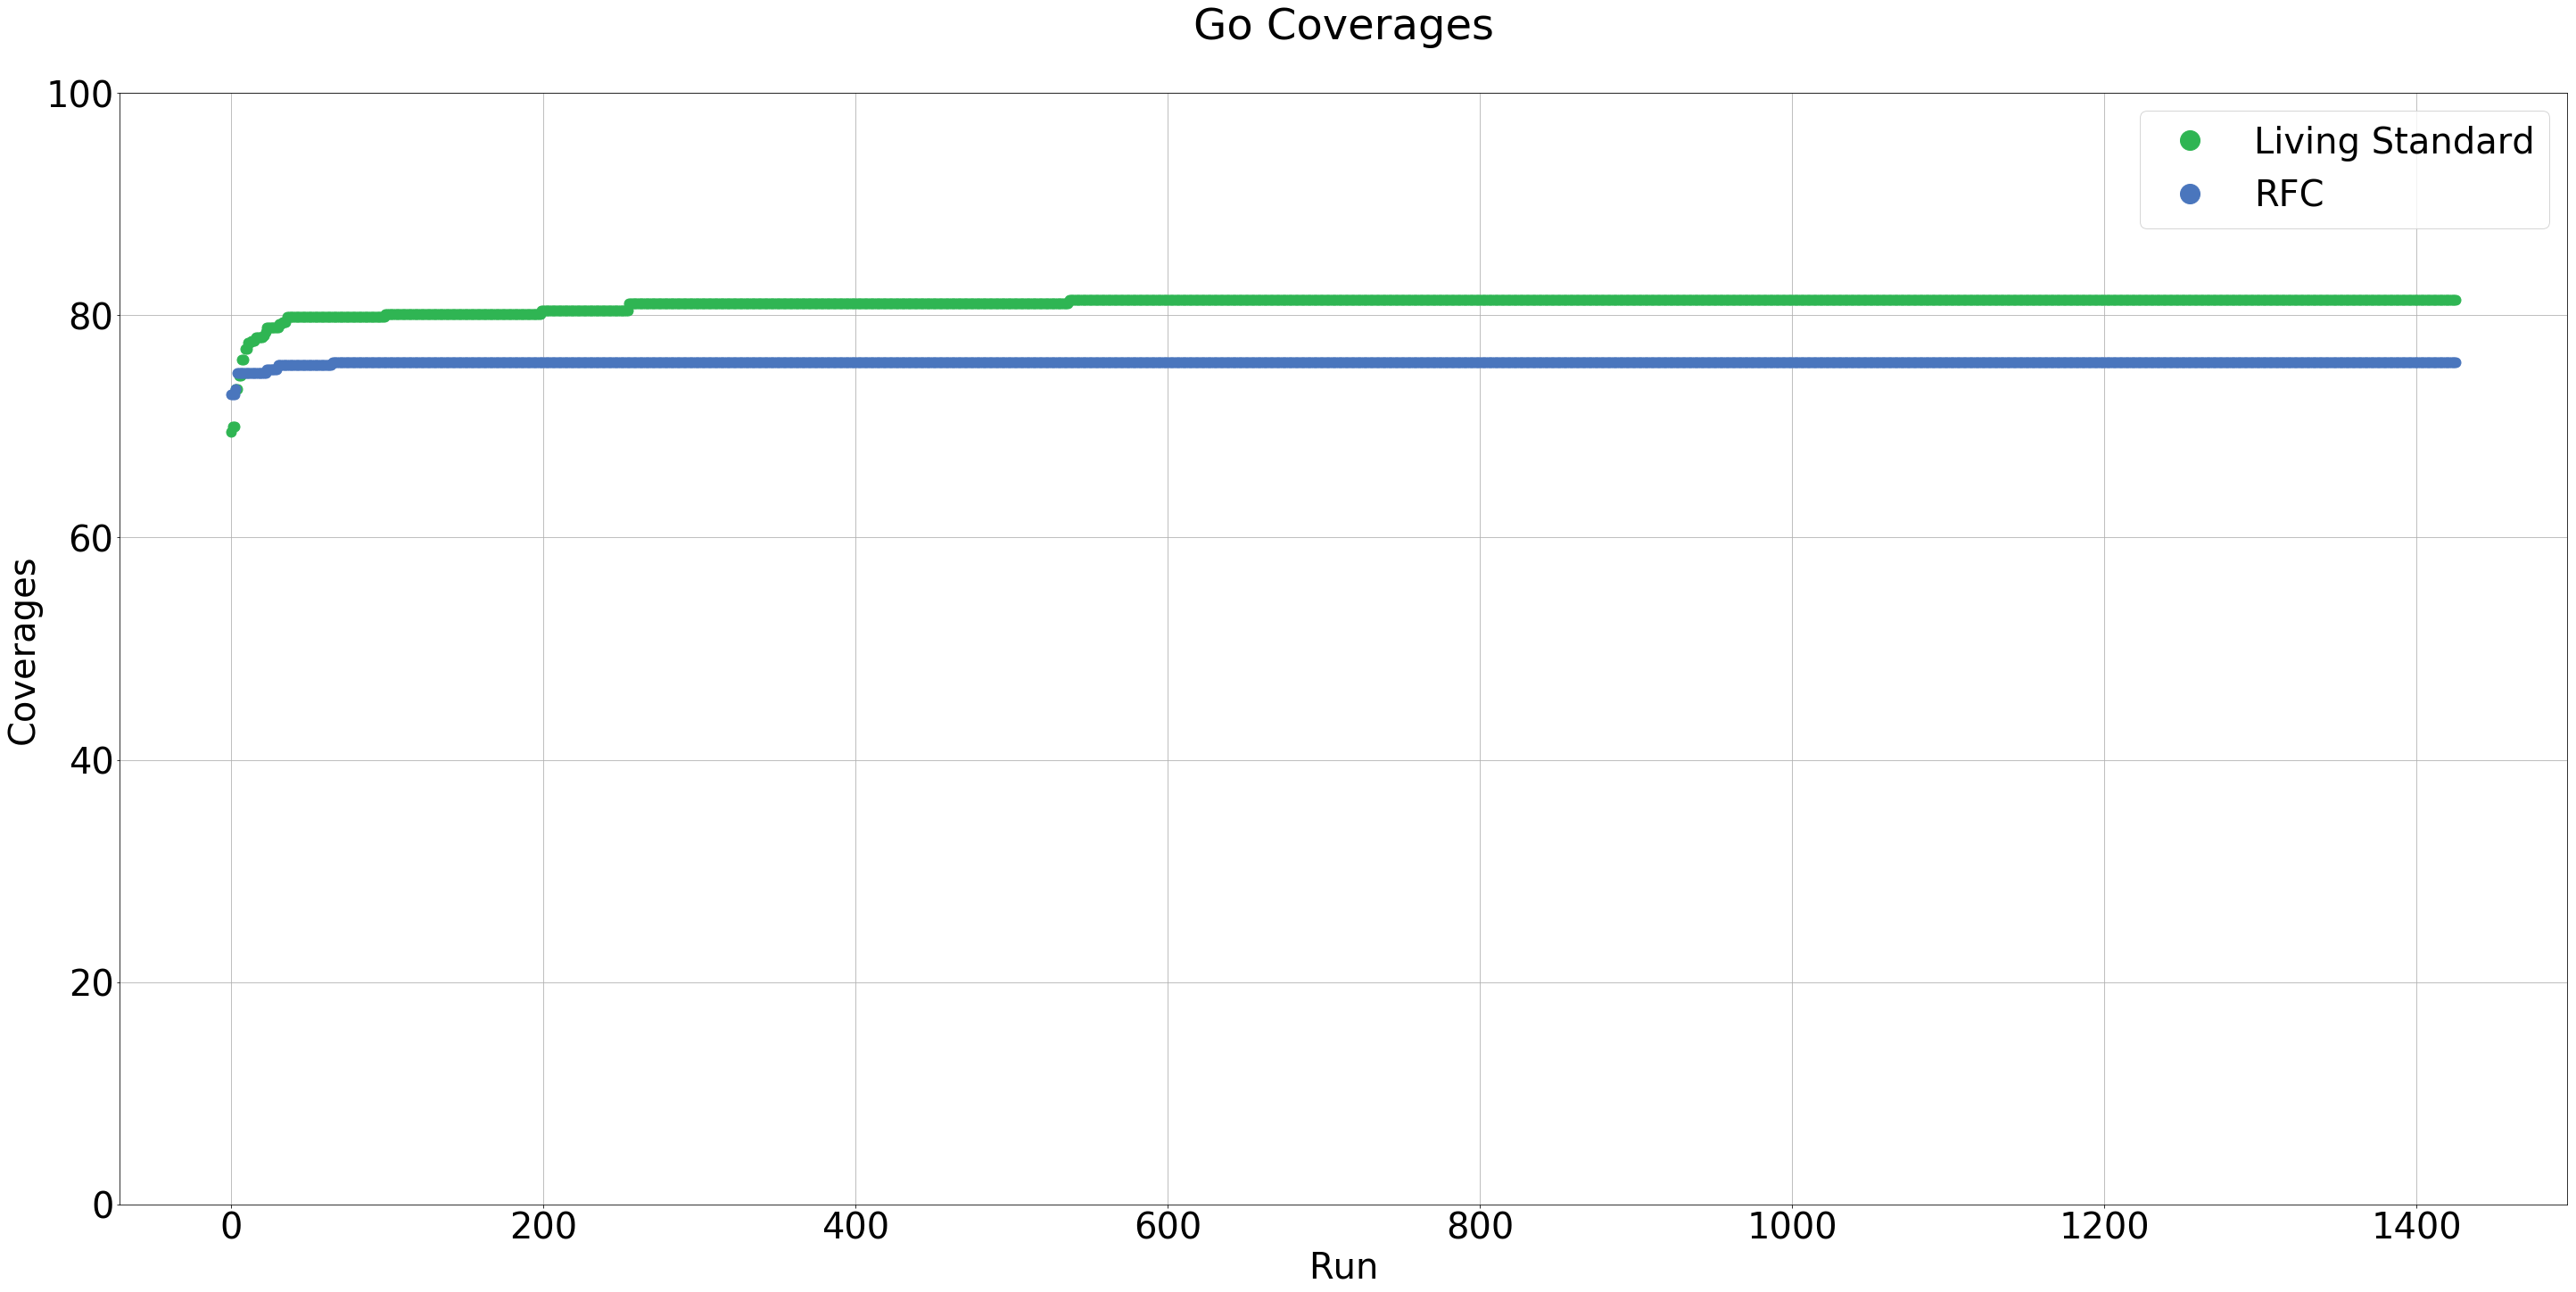

,Living Standard,RFC
count,1426.00,1426.00
mean,81.03,75.77
std,0.89,0.20
min,69.50,72.90
25%,81.10,75.80
50%,81.40,75.80
75%,81.40,75.80
max,81.40,75.80


#### Overall max results

Living Standard Max Coverage: 81.4%                      reached in run 537                      

[full max run results](./ls/go/resultoverview.html)                      

[coverage report](./ls/go/Go/index.html)

RFC Max Coverage: 75.8%                      reached in run 65                     

[full max run results](./rfc/go/resultoverview.html)                     

[coverage report](./rfc/go/Go/index.html)

### Java

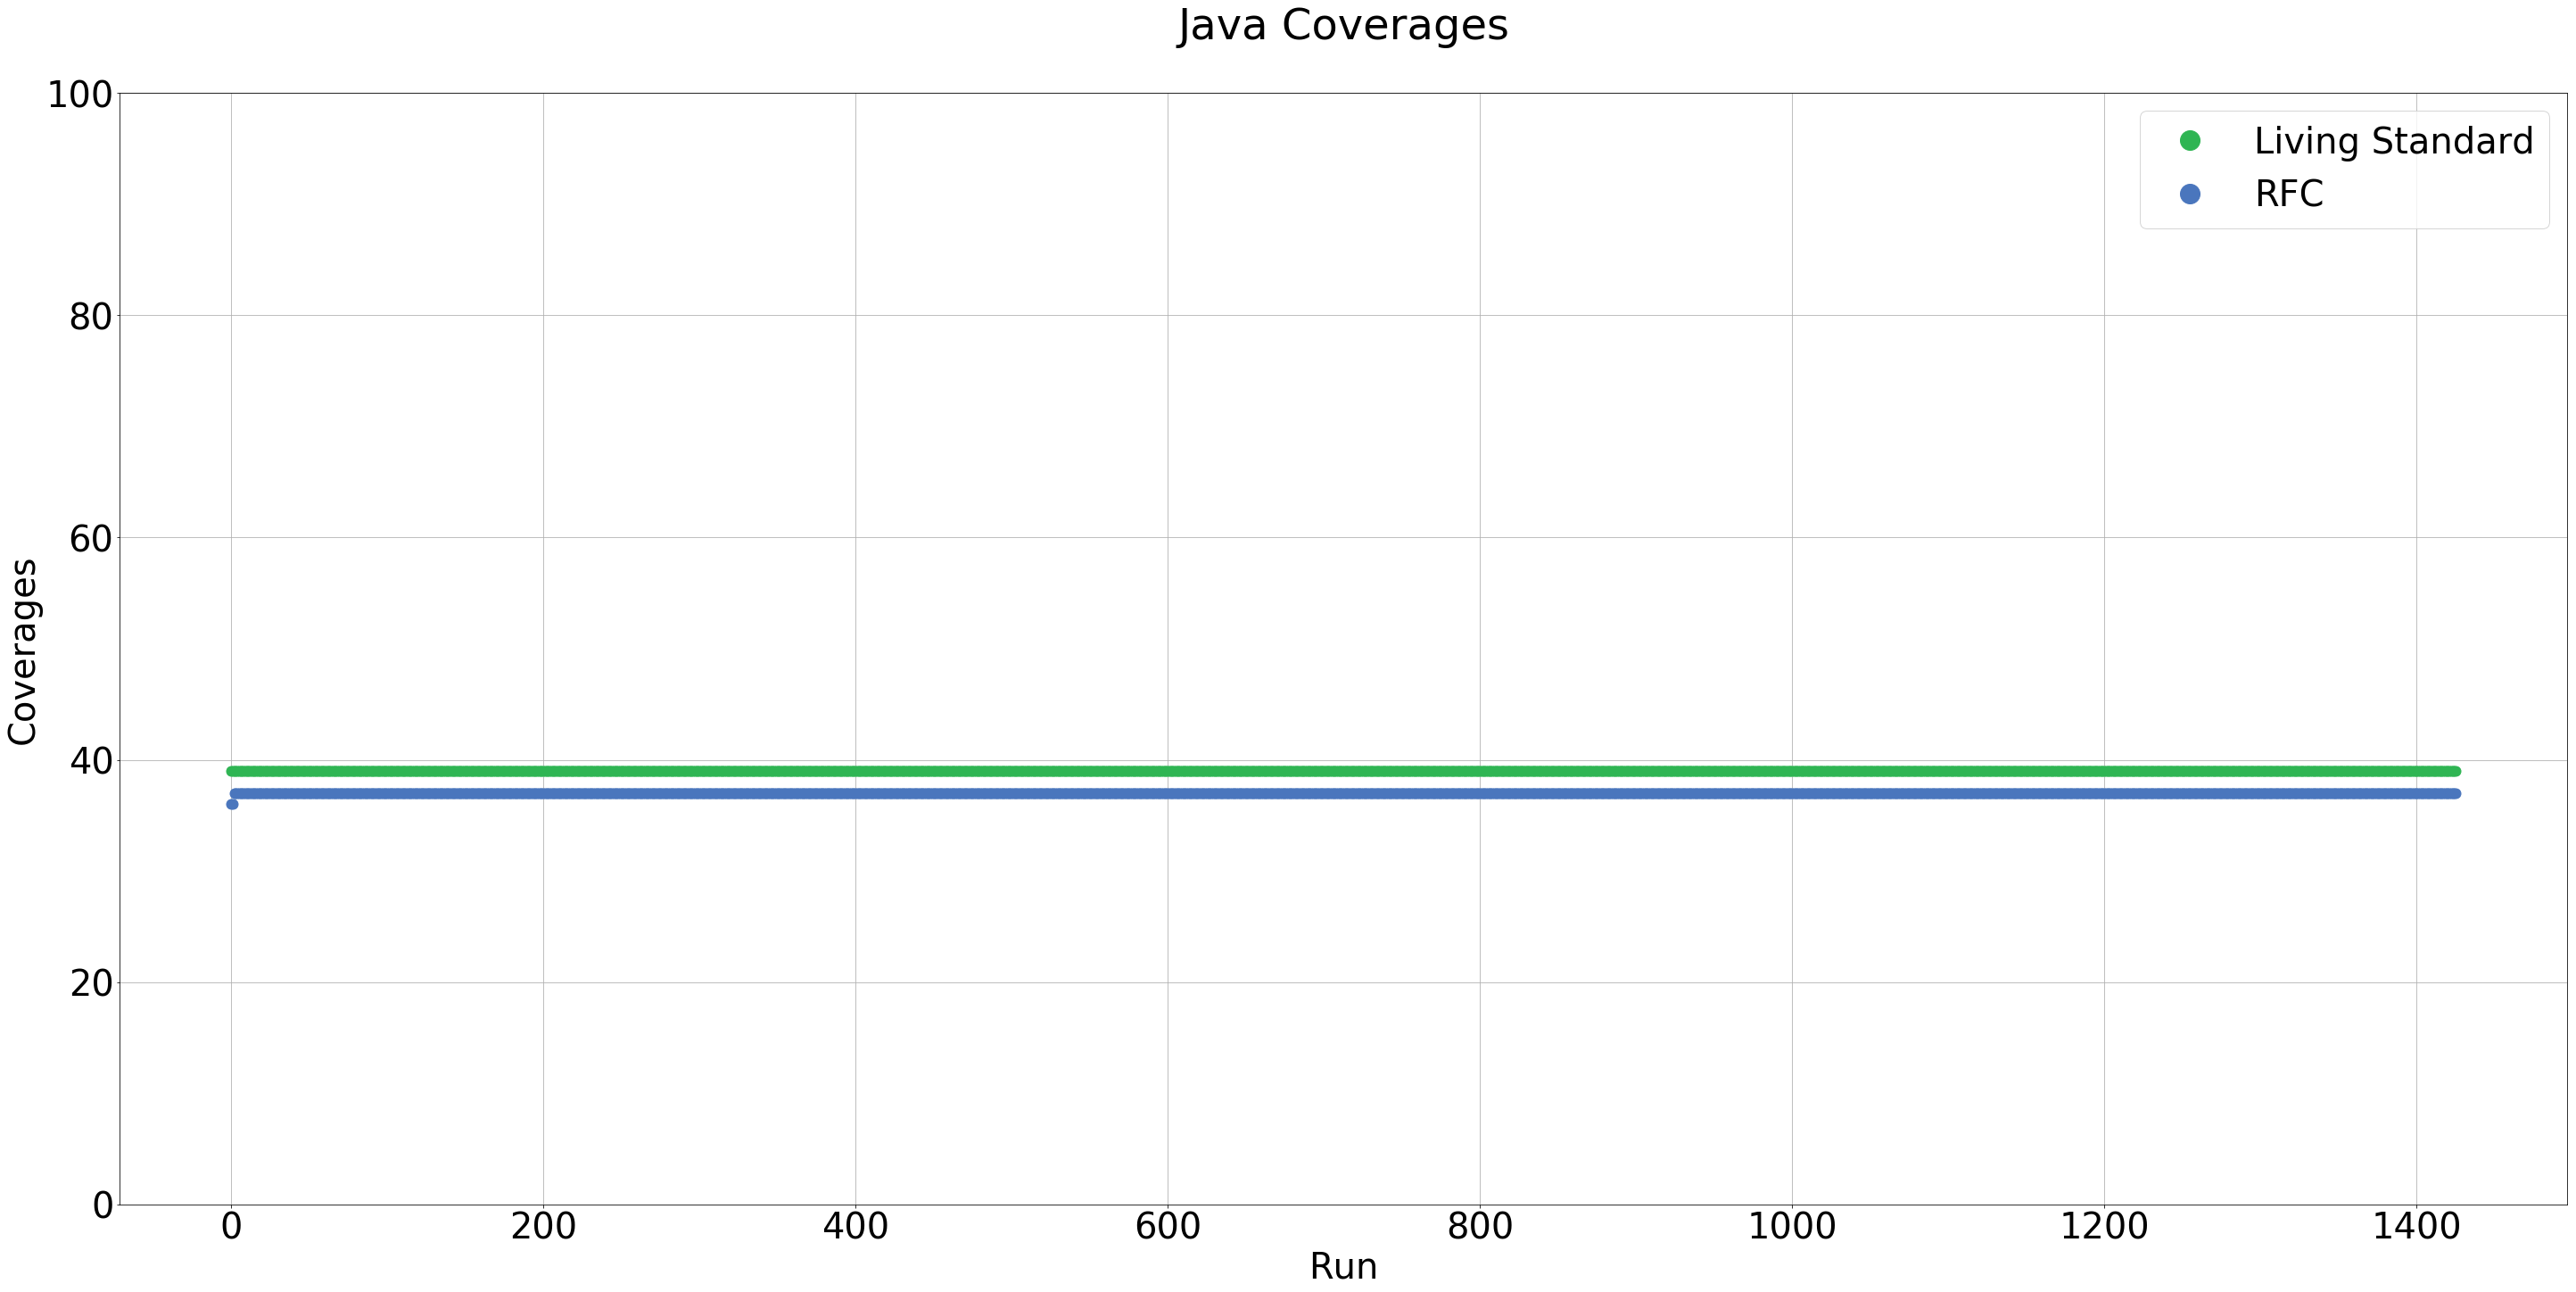

,Living Standard,RFC
count,1426.00,1426.00
mean,39.00,37.00
std,0.00,0.04
min,39.00,36.00
25%,39.00,37.00
50%,39.00,37.00
75%,39.00,37.00
max,39.00,37.00


#### Overall max results

Living Standard Max Coverage: 39.0%                      reached in run 0                      

[full max run results](./ls/java/resultoverview.html)                      

[coverage report](./ls/java/Java/java/net/URL.html)

RFC Max Coverage: 37.0%                      reached in run 2                     

[full max run results](./rfc/java/resultoverview.html)                     

[coverage report](./rfc/java/Java/java/net/URL.html)

### Javascripturijs

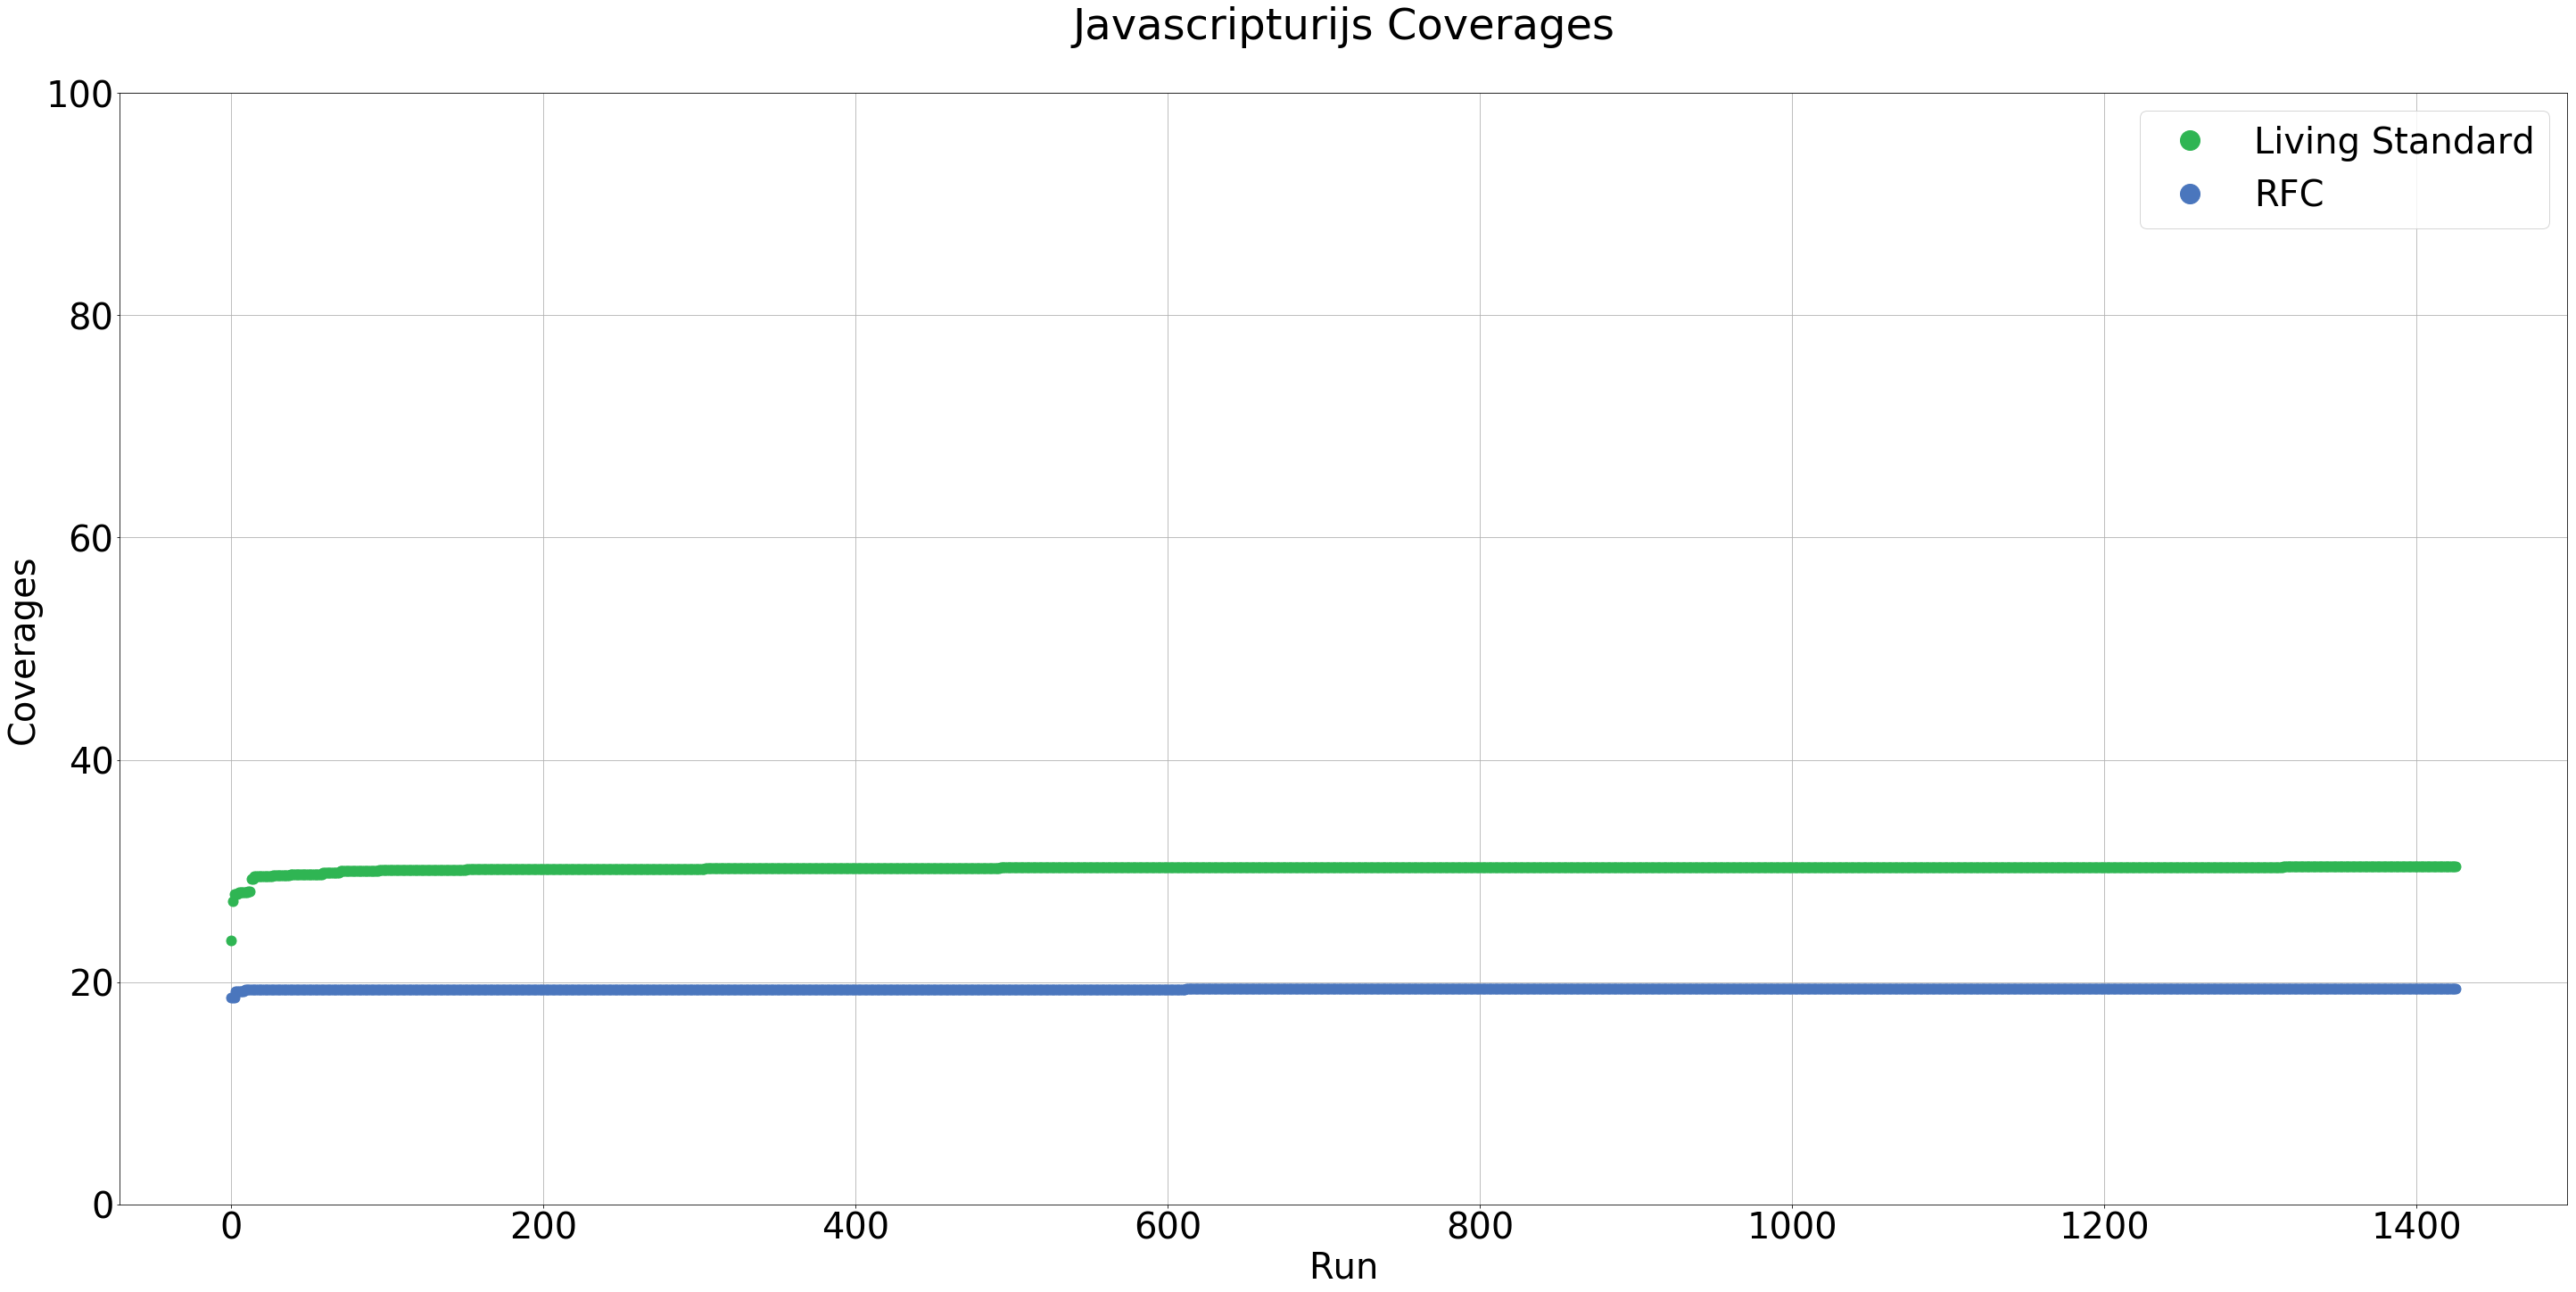

,Living Standard,RFC
count,1426.00,1426.00
mean,30.24,19.37
std,0.31,0.06
min,23.74,18.63
25%,30.24,19.32
50%,30.33,19.41
75%,30.33,19.41
max,30.42,19.41


#### Overall max results

Living Standard Max Coverage: 30.42%                      reached in run 1315                      

[full max run results](./ls/javascripturijs/resultoverview.html)                      

[coverage report](./ls/javascripturijs/JavaScript/urijs/URI.js.html)

RFC Max Coverage: 19.41%                      reached in run 612                     

[full max run results](./rfc/javascripturijs/resultoverview.html)                     

[coverage report](./rfc/javascripturijs/JavaScript/urijs/URI.js.html)

### Javascriptwhatwg-url

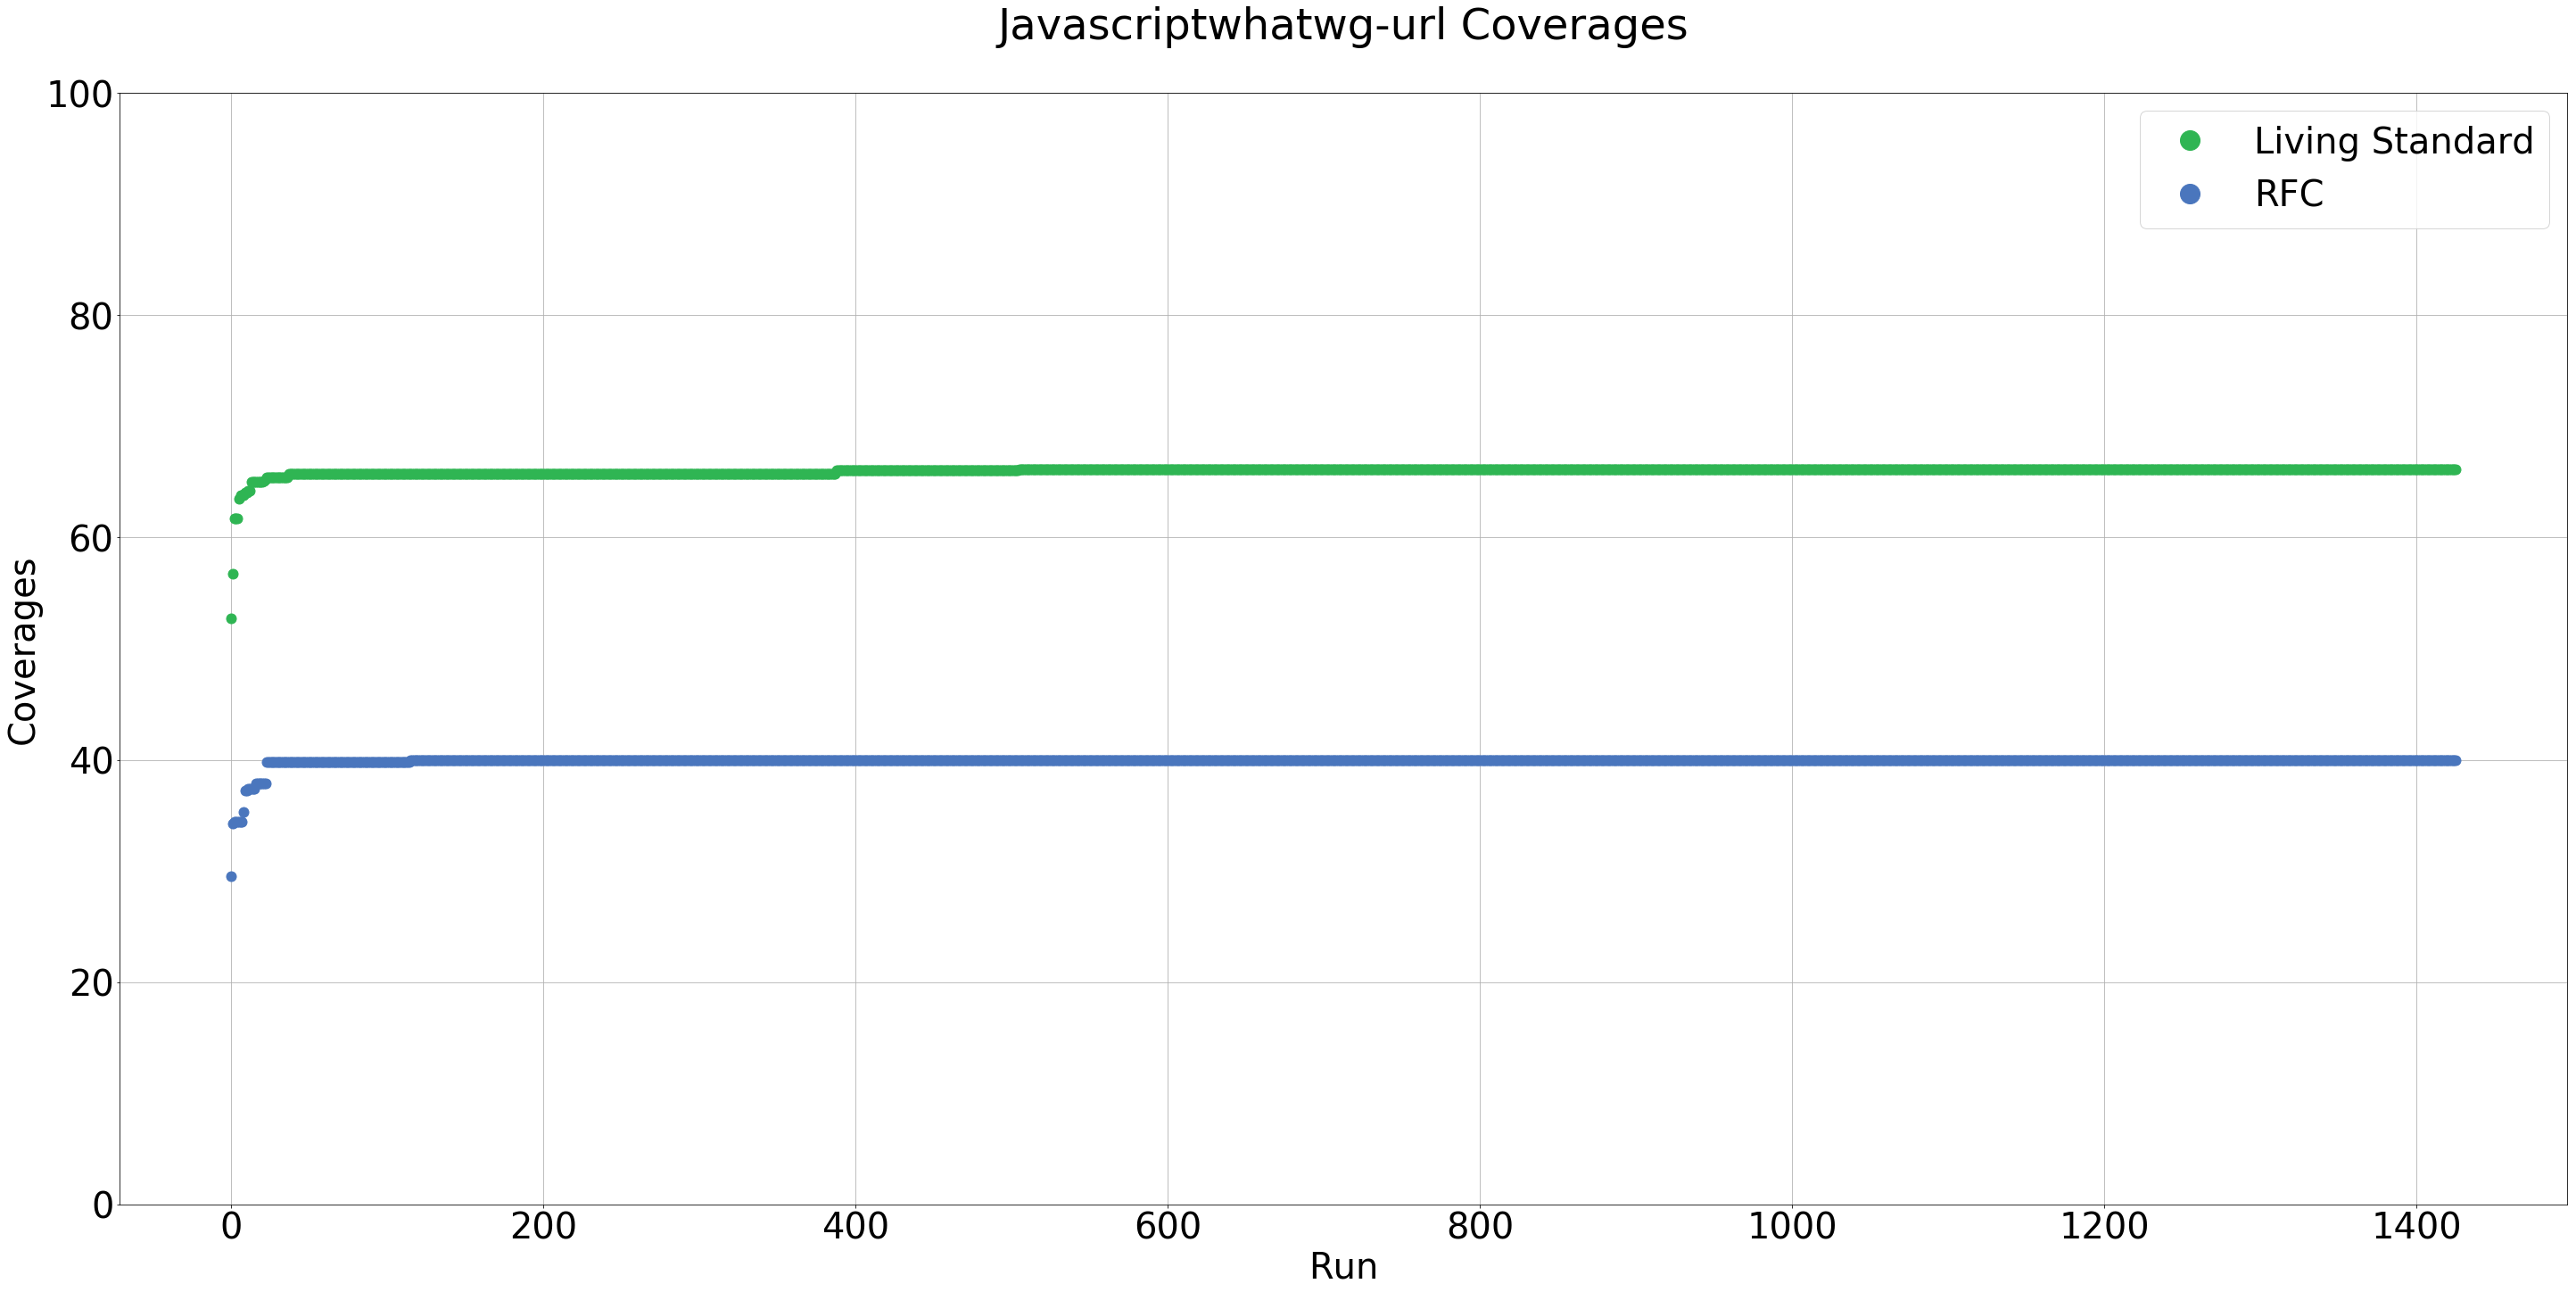

,Living Standard,RFC
count,1426.00,1426.00
mean,65.99,39.87
std,0.54,0.54
min,52.76,29.51
25%,65.72,39.94
50%,66.17,39.94
75%,66.17,39.94
max,66.17,39.94


#### Overall max results

Living Standard Max Coverage: 66.17%                      reached in run 505                      

[full max run results](./ls/javascriptwhatwg-url/resultoverview.html)                      

[coverage report](./ls/javascriptwhatwg-url/JavaScript/whatwg-url/whatwg-url/dist/url-state-machine.js.html)

RFC Max Coverage: 39.94%                      reached in run 115                     

[full max run results](./rfc/javascriptwhatwg-url/resultoverview.html)                     

[coverage report](./rfc/javascriptwhatwg-url/JavaScript/whatwg-url/whatwg-url/dist/url-state-machine.js.html)

### Php

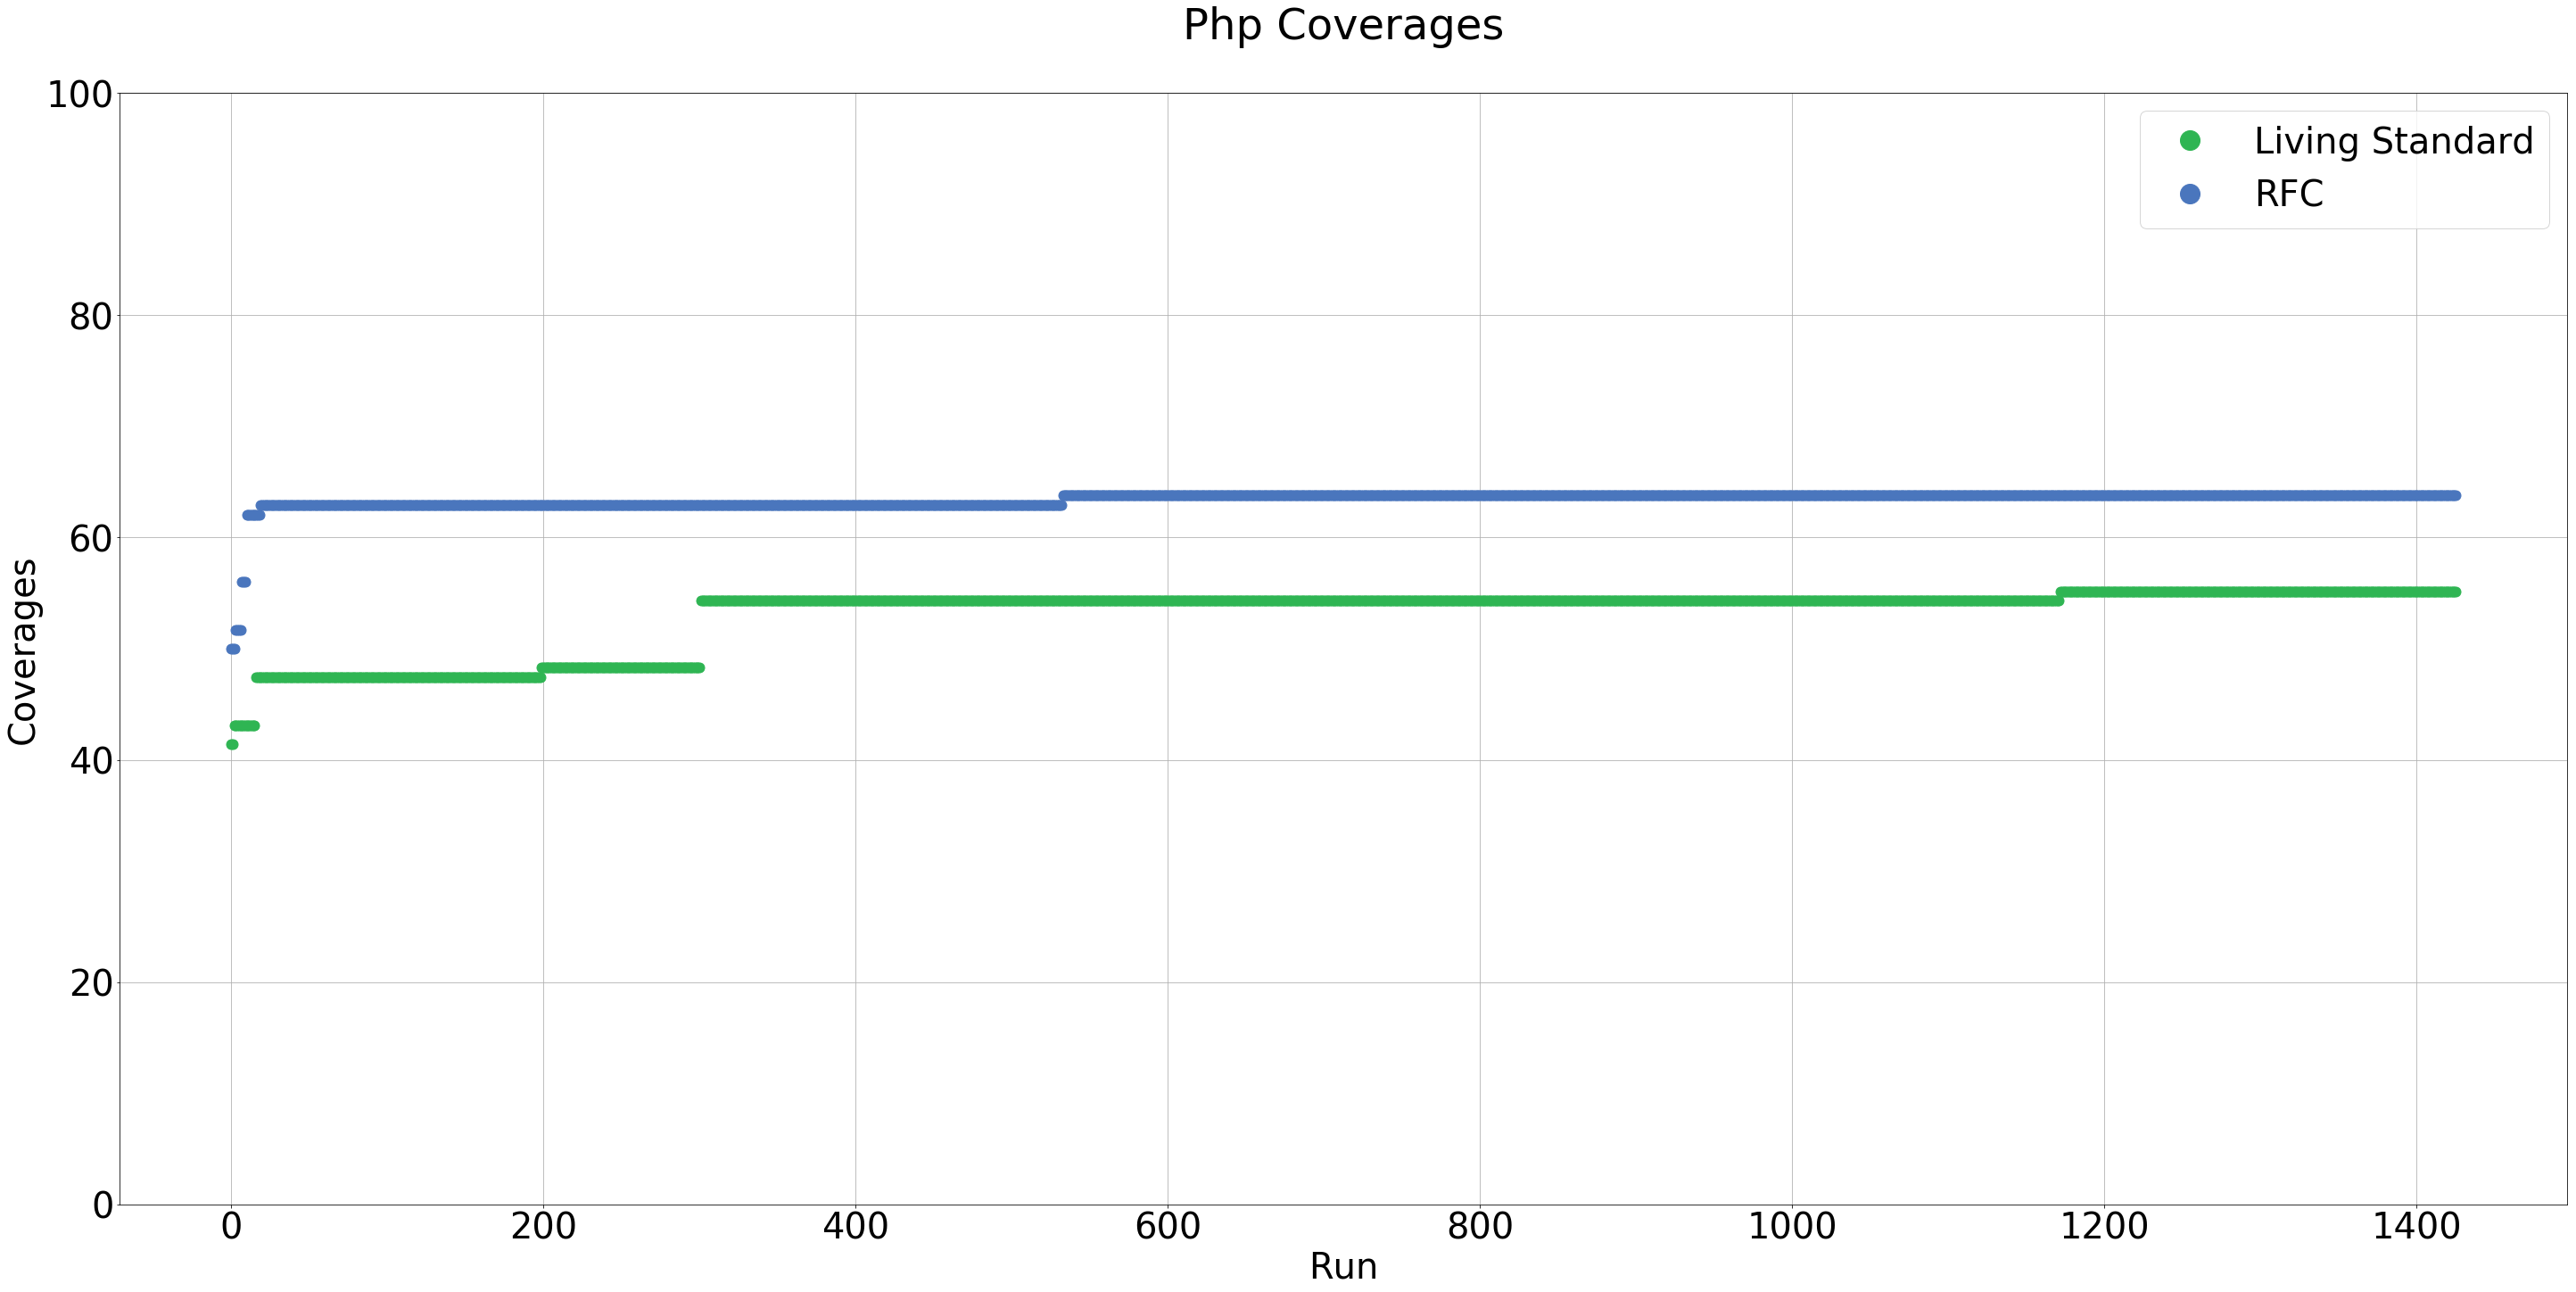

,Living Standard,RFC
count,1426.00,1426.00
mean,53.02,63.39
std,2.94,1.03
min,41.38,50.00
25%,54.31,62.93
50%,54.31,63.79
75%,54.31,63.79
max,55.17,63.79


#### Overall max results

Living Standard Max Coverage: 55.17%                      reached in run 1172                      

[full max run results](./ls/php/resultoverview.html)                      

[coverage report](./ls/php/PHP/index.html)

RFC Max Coverage: 63.79%                      reached in run 533                     

[full max run results](./rfc/php/resultoverview.html)                     

[coverage report](./rfc/php/PHP/index.html)

### Python

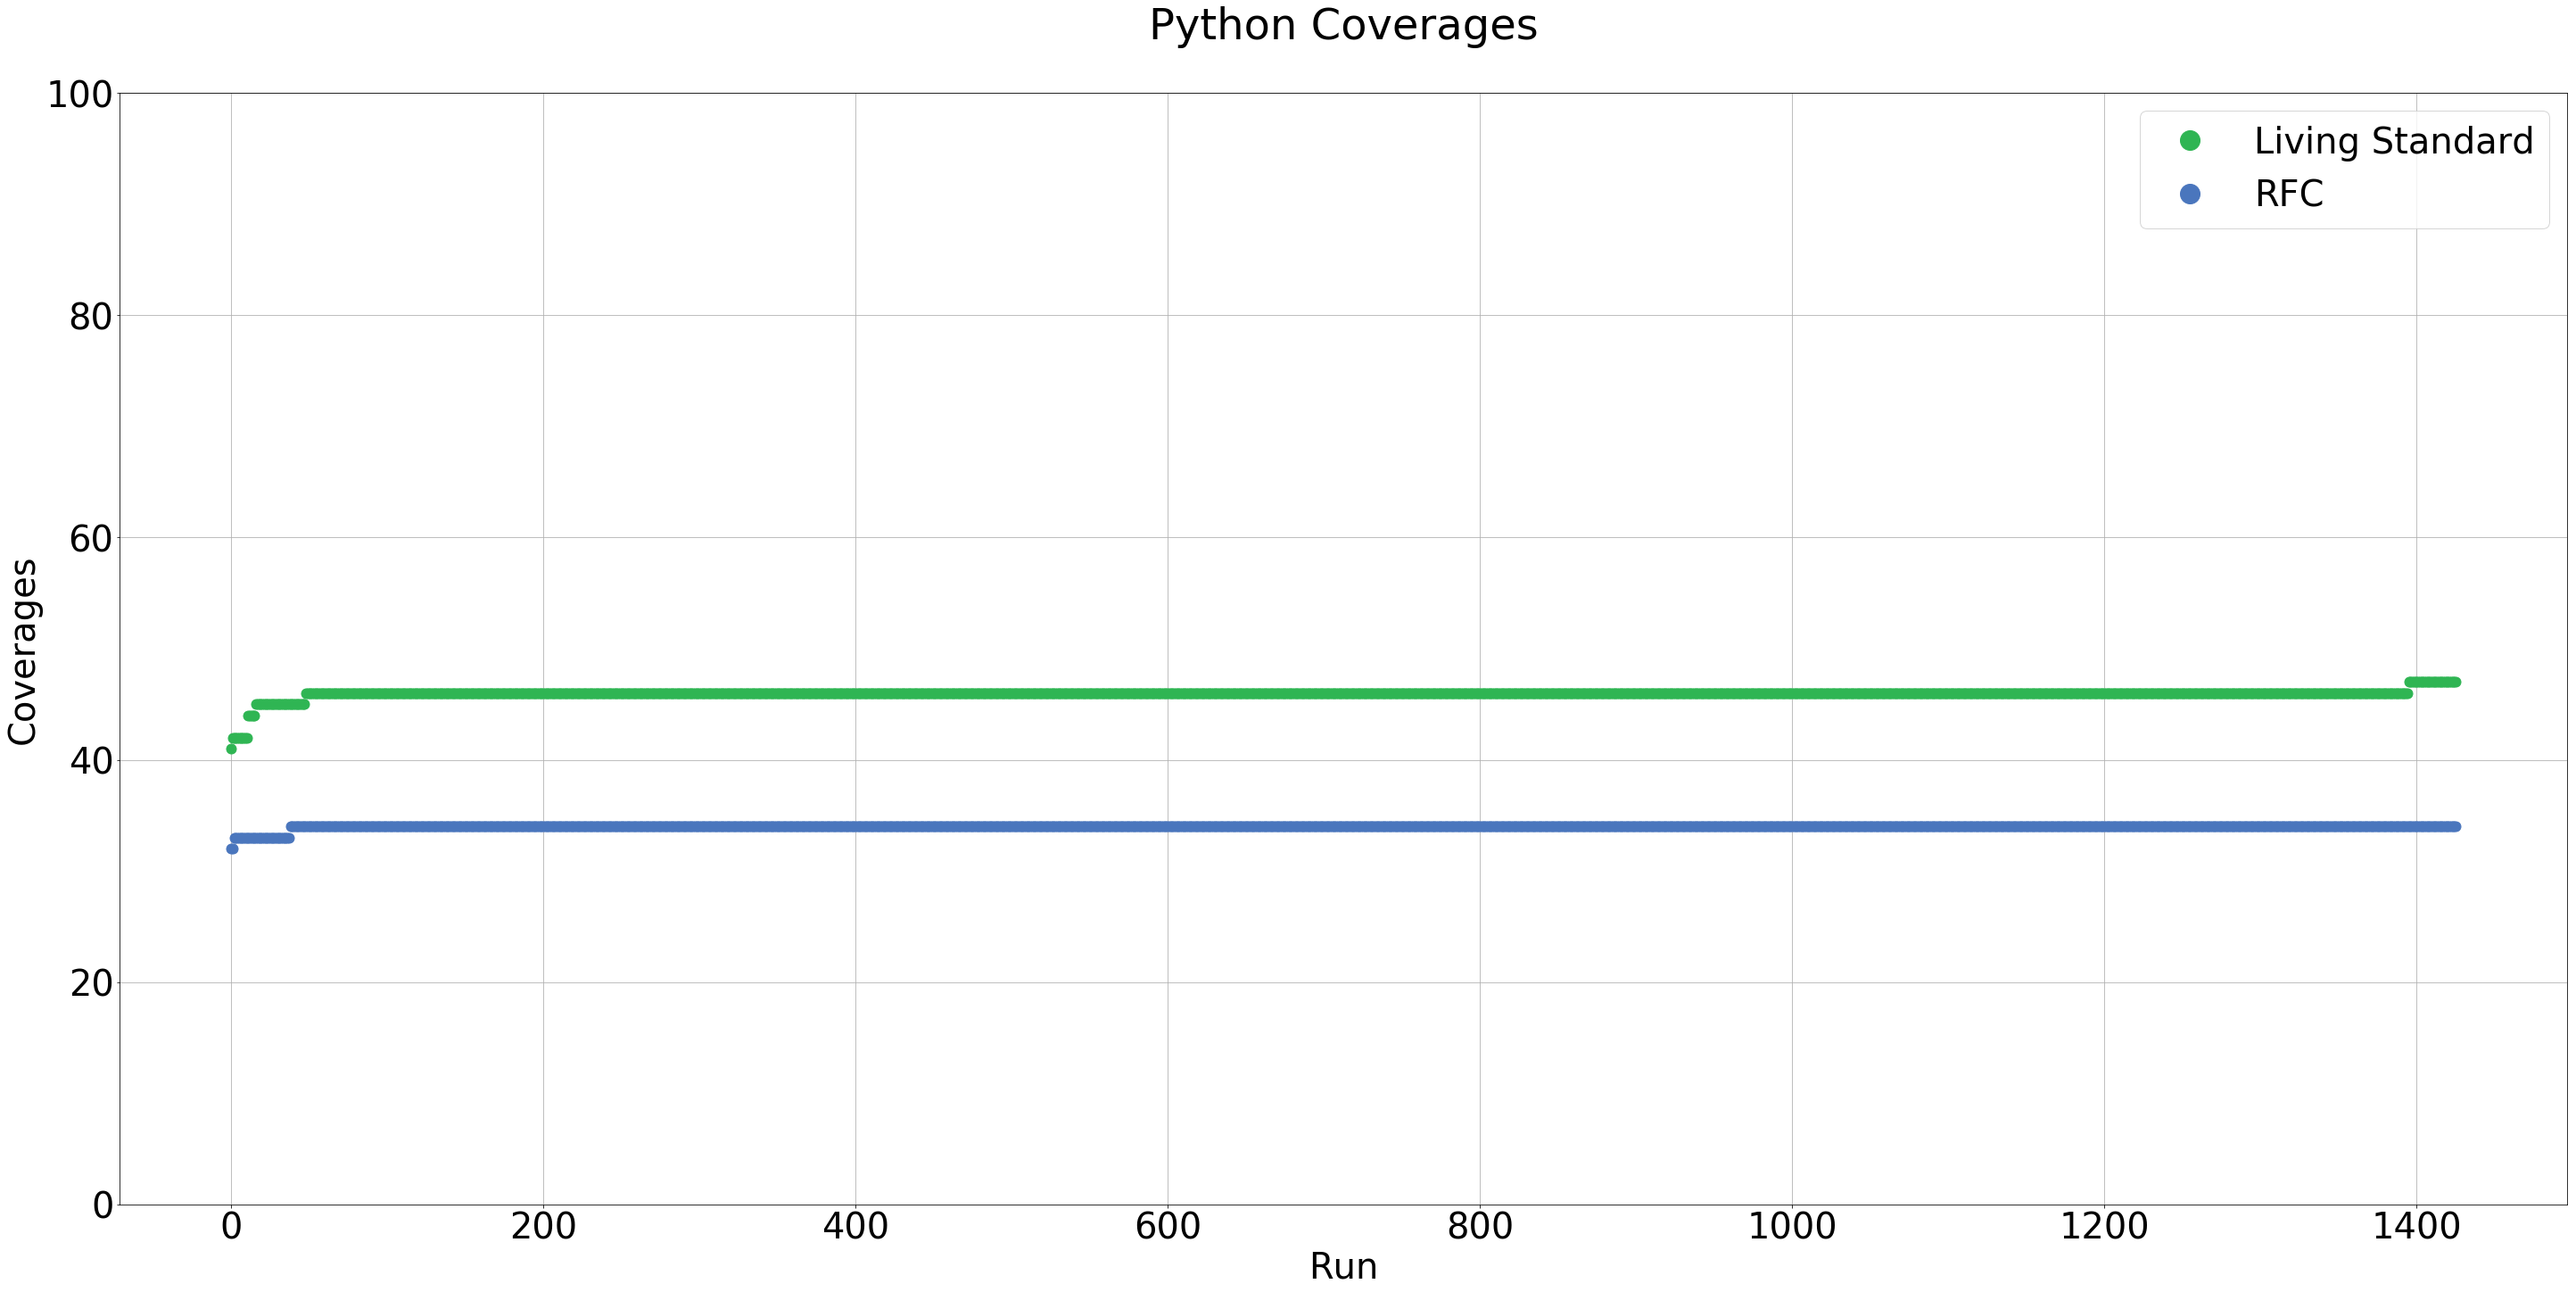

,Living Standard,RFC
count,1426.00,1426.00
mean,45.96,33.97
std,0.43,0.17
min,41.00,32.00
25%,46.00,34.00
50%,46.00,34.00
75%,46.00,34.00
max,47.00,34.00


#### Overall max results

Living Standard Max Coverage: 47.0%                      reached in run 1395                      

[full max run results](./ls/python/resultoverview.html)                      

[coverage report](./ls/python/Python/_usr_lib_python3_6_urllib_parse_py.html)

RFC Max Coverage: 34.0%                      reached in run 38                     

[full max run results](./rfc/python/resultoverview.html)                     

[coverage report](./rfc/python/Python/_usr_lib_python3_6_urllib_parse_py.html)

### Ruby

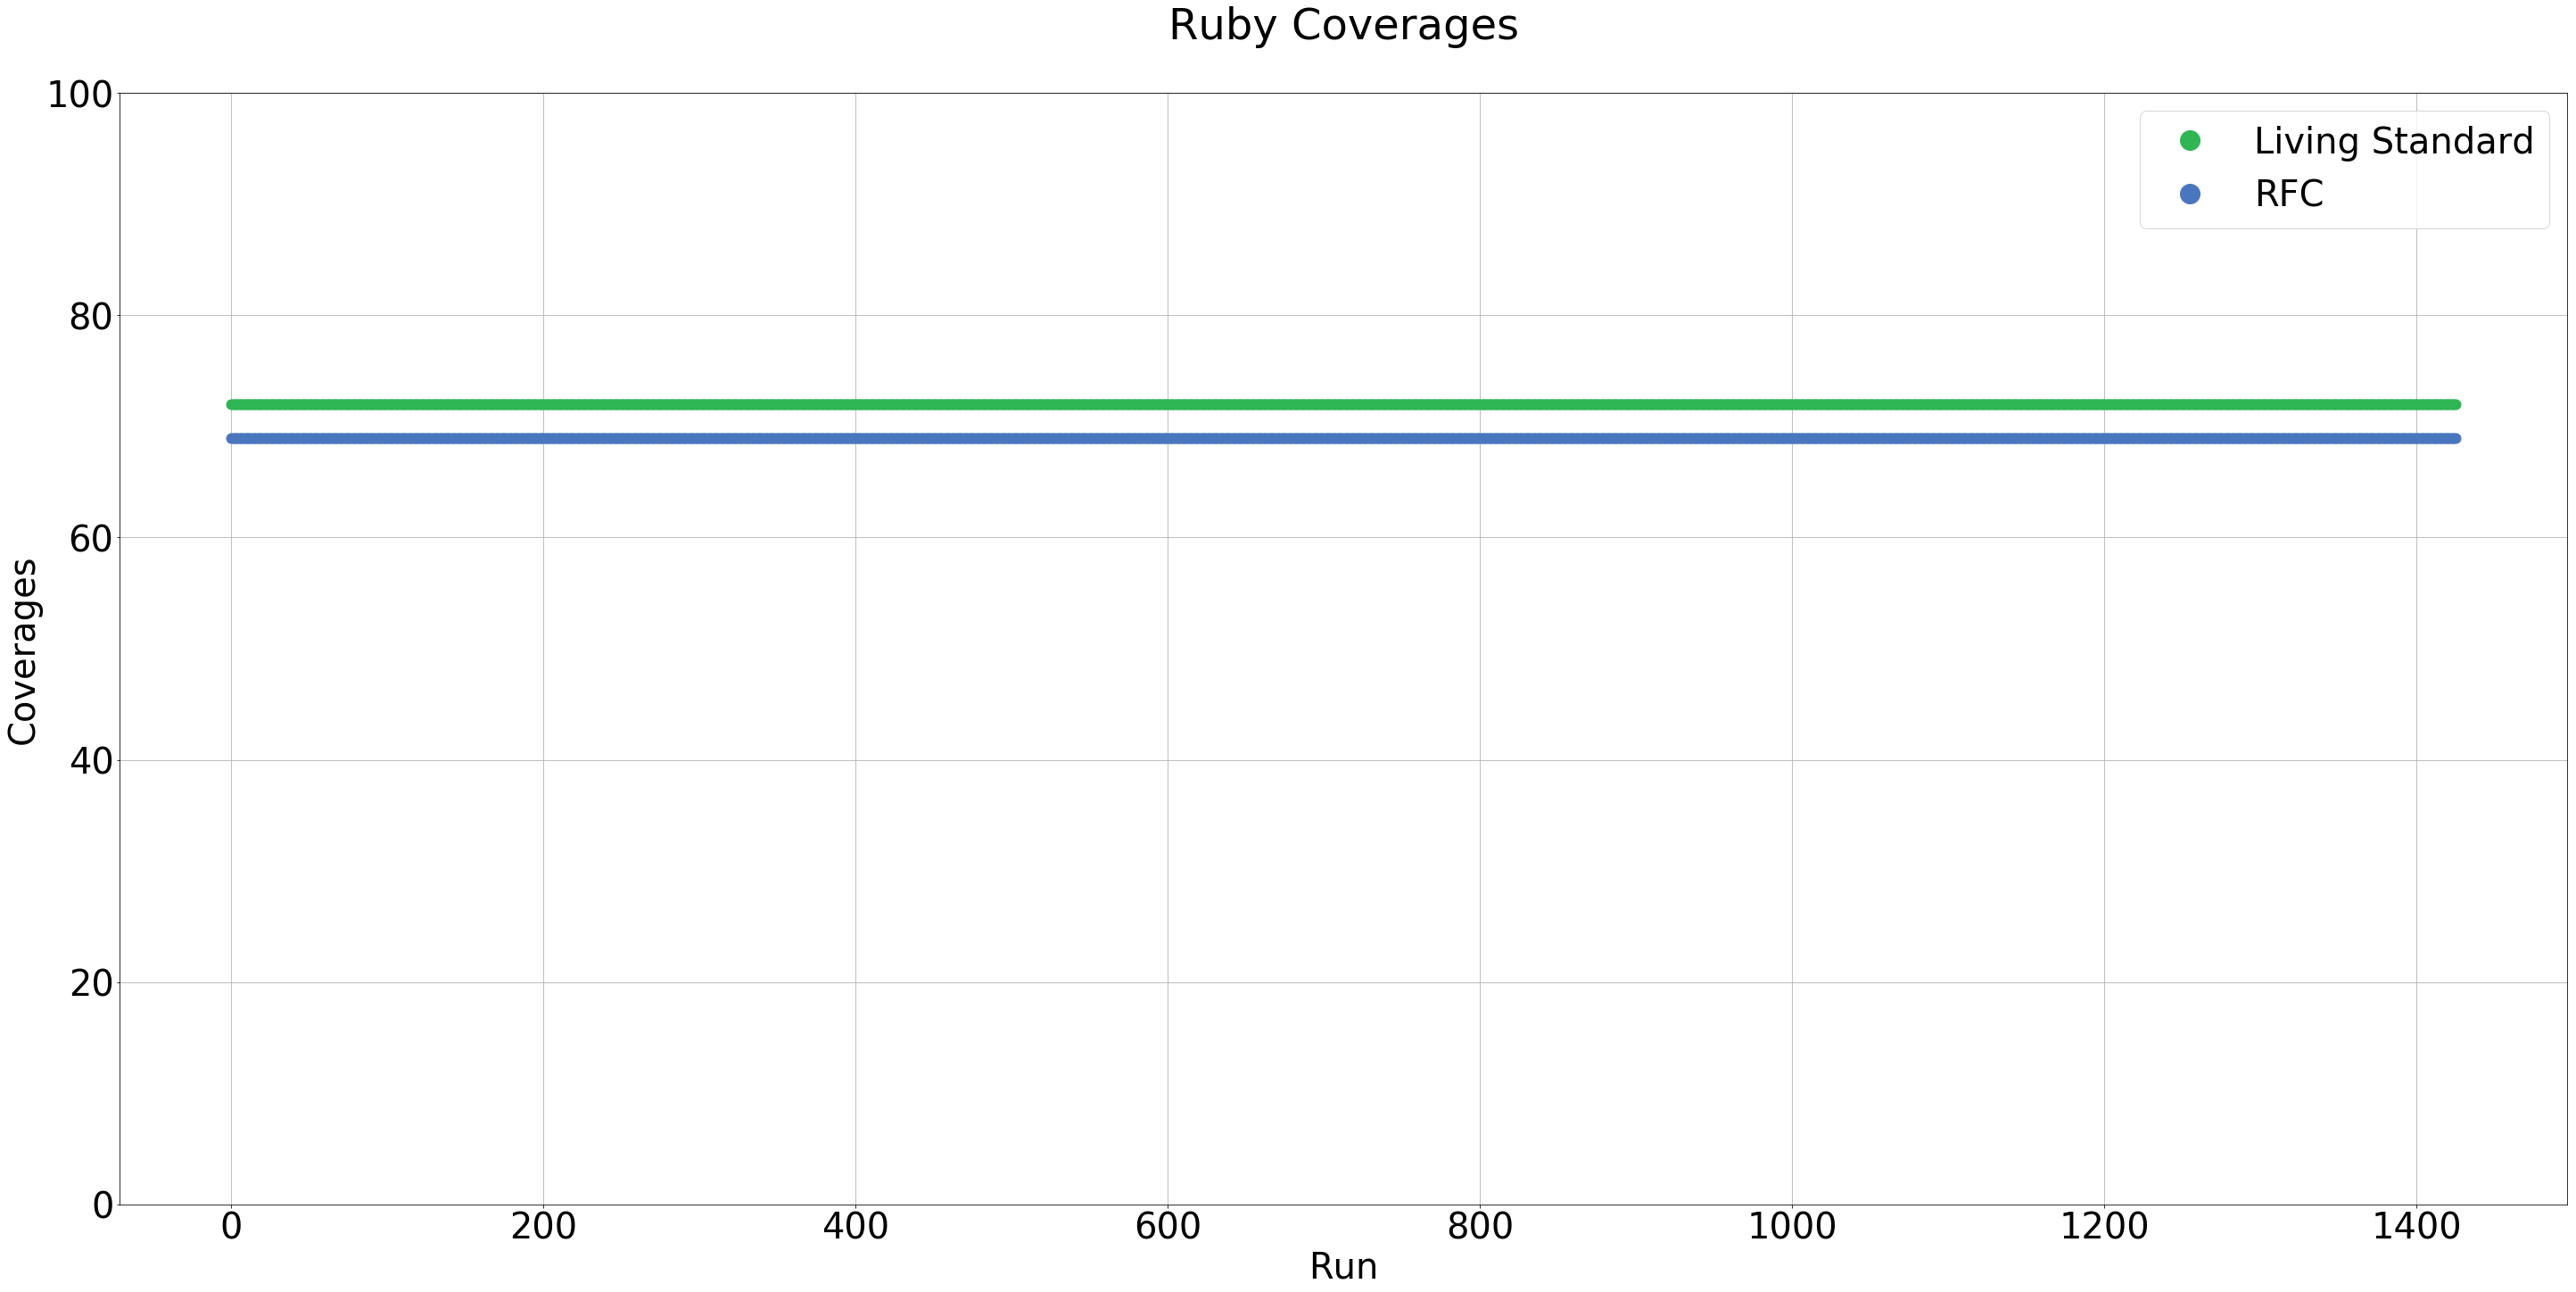

,Living Standard,RFC
count,1426.00,1426.00
mean,72.02,68.91
std,0.00,0.00
min,72.02,68.91
25%,72.02,68.91
50%,72.02,68.91
75%,72.02,68.91
max,72.02,68.91


#### Overall max results

Living Standard Max Coverage: 72.02%                      reached in run 0                      

[full max run results](./ls/ruby/resultoverview.html)                      

[coverage report](./ls/ruby/Ruby/index.html)

RFC Max Coverage: 68.91%                      reached in run 0                     

[full max run results](./rfc/ruby/resultoverview.html)                     

[coverage report](./rfc/ruby/Ruby/index.html)

In [74]:
dfs={}
plots=[]
for parser in sorted(parsers):
    dfs[parser], plot=compareGrammarResults(parser, ls_df, "Living Standard", rfc_df, "RFC")
    plots+=[plot]
    

# focusing on a range
#for parser in parsers:
#    dfs[parser]=compareGrammarResults(parser, ls_df, "Living Standard", rfc_df, "RFC", (0,10))
    



